#Usecase
To analyze Ride_Sharing Electrice Cycles data, understand the factors affecting the demand for these
shared electric cycles in the American market and provide actionable recommendation to increase
revenue.
###Data Dictionary : 
- datetime: datetime - season: season (1: spring, 2: summer, 3: fall, 4: winter) -
holiday : weather day is a holiday or not (extracted from ttp://dchr.dc.gov/page/holiday-schedule)
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0. weather: - 1: Clear, Few
clouds, partly cloudy, partly cloudy - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds,
Mist - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered
clouds - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog - temp: temperature
in Celsius - atemp: feeling temperature in Celsius - humidity: humidity - windspeed: wind speed
- casual: count of casual users - registered: count of registered users - count: count of total rental
bikes including both casual and registered
Importing relevant libraries


In [1]:
from google.colab import files
uploaded = files.upload()

Saving bike_sharing.csv to bike_sharing.csv


Importing relevant libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

#1.1 Exploratory Data Analysis
Helper Functions for basic analysis of the data

In [3]:
def missing_values(data):
  '''
  This function computes the number and percentages of null values for each feature.
  Parameters:
  data (pandas.DataFrame): Data under analysis
  Returns:
  A pandas.DataFrame with Null Counts and Percentages for each feature.
  '''
  null_counts = data.isna().sum()
  print(f"# Data points = {data.shape[0]}")
  return pd.DataFrame(
  {
  'Null Counts' : null_counts,
  'Null Percentages' : null_counts/data.shape[0]
  }
  )

In [46]:
def remove_outliers(data, features, method='iqr'):
    '''
    Removes outliers based on requested method.
    Parameters:
    data (pandas.DataFrame): Data under analysis
    features (list): List of features for outlier removal
    method (string): Accepts two values "iqr", "z-score"
    Returns:
    data (pandas.Series): Cleaned Data
    outliers (pandas.Series):
    '''
    intial_shape = data.shape
    outliers = pd.DataFrame()
    if method == 'iqr':
        for f in features:
            q1 = data[f].quantile(0.25)
            q3 = data[f].quantile(0.75)
            iqr = q3-q1
            f_outliers = data.loc[(data[f]<q1-1.5*iqr) | (data[f]>q3+1.5*iqr)]
            outliers = outliers.append(f_outliers)
            data.drop(f_outliers.index, inplace=True)
    elif method == 'z-score':
        for f in features:
            mean = data[f].mean()
            std = data[f].std()
            f_outliers = data.loc[((data[f]-mean)/std<-3) | ((data[f]-mean)/std>3)]
            outliers = outliers.append(f_outliers)
            data.drop(f_outliers.index, inplace=True)
    print(f'{outliers.shape[0]*100/intial_shape[0]}% data detected as outlier.')
    return data, outliers

In [4]:
def univariate_analysis(data, features, type_of_feature, width = 16, height =9):
  '''
  This function helps to perform univariate analysis by
  plotting relevant plots for different types of features.
  For Categorical features: Count Plot and Pie Chart
  For Continuous : Boxplot and Histogram
  Parameters:
  data (pd.DataFrame): Data under analysis
  features (list): List of continuous/categorical features
  type_of_feature (string): continuous or categorical
  width (int): width of 1 axes
  height (int): height of 1 axes
  Returns:
  None
  '''
  n_features = len(features)
  figsize = (width, height*n_features)
  fig, ax = plt.subplots(nrows=n_features, ncols=2, figsize=figsize,constrained_layout=True)
  if n_features == 1:
    ax = [ax]
  if type_of_feature == 'continuous':
    for i in range(n_features):
      f = features[i]
      ax[i][0].set_title(f"Boxplot for {f}")
      sns.boxplot(y = data[f], ax=ax[i][0])
      ax[i][0].set_ylabel(f)
      sns.histplot(data[f], ax=ax[i][1], kde=True)
      ax[i][1].axvline(data[f].mean(), color='r', linestyle='--', label="Mean")
      ax[i][1].axvline(data[f].median(), color='g', linestyle='-',label="Median")
      ax[i][1].axvline(data[f].mode()[0], color='royalblue', linestyle='--',label="Mode")
      ax[i][1].set_title(f"Histplot for {f}")
      ax[i][1].legend()
  elif type_of_feature == 'categorical':
    for i in range(n_features):
      f = features[i]
      counts = df[f].value_counts()
      ax[i][0].set_title(f"Count Plot for {f}")
      counts.plot.bar(ax=ax[i][0])
      ax[i][0].set_ylabel("Counts")
      ax[i][0].set_xlabel(f)
      ax[i][1].set_title(f"Pie chart for {f}")
      counts.plot.pie(autopct='%0.0f%%', ax=ax[i][1])
    fig.suptitle(f"Univariate analysis of {type_of_feature} features",fontweight="bold")
    plt.show()

In [5]:
def bivariate_analysis(data, features, type_of_feature, group_by, width=16, height=9):
    '''
    This function helps to perform bi-variate analysis by
    plotting relevant plots for different types of features across
    a particular categorical feature.
    
    For Categorical features: Count Plot with hue as "group_by"
    For Continuous: Violinplot with x axis as "group_by" and
    KDE plot with hue as "group_by"
    
    Parameters:
        data (pd.DataFrame): Data under analysis
        features (list): List of continuous/categorical features
        type_of_feature (string): continuous or categorical
        group_by (string): Feature Name to group by plots with
        width (int): width of 1 axes
        height (int): height of 1 axes
    
    Returns:
        None
    '''
    
    n_features = len(features)
    figsize = (width, height*n_features)
    
    if type_of_feature == 'continuous':
        fig, ax = plt.subplots(nrows=n_features, ncols=2, figsize=figsize, constrained_layout=True)
        if n_features == 1:
            ax = [ax]
        for i in range(n_features):
            f = features[i]
            ax[i][0].set_title(f"Violinplot for {f} by {group_by}")
            sns.violinplot(data=data, y=f, x=group_by, ax=ax[i][0])
            ax[i][0].set_ylabel(f)
            sns.kdeplot(data=data, x=f, hue=group_by, ax=ax[i][1])
            ax[i][1].set_title(f"KDE plot for {f} by {group_by}")
    
    elif type_of_feature == 'categorical':
        fig, ax = plt.subplots(nrows=n_features, ncols=2, figsize=figsize)
        if n_features == 1:
            ax = [ax]
        for i in range(n_features):
            f = features[i]
            ax[i][0].set_title(f"Count plot for {f} by {group_by}")
            sns.countplot(data=data, x=f, hue=group_by, ax=ax[i][0])
            ax[i][0].set_ylabel("Counts")
            ax[i][0].set_xlabel(f)
            ax[i][1].set_title(f"Count plot for {group_by} by {f}")
            sns.countplot(data=data, x=group_by, hue=f, ax=ax[i][1])
            ax[i][1].set_ylabel("Counts")
            ax[i][1].set_xlabel(group_by)
            
    fig.suptitle(f"Bivariate analysis of {type_of_feature} features", fontweight="bold")
    plt.show()


In [6]:
#Importing the data
df=pd.read_csv("bike_sharing.csv")

In [7]:
df.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

Let’s try to understand what is this data about. Seems like data tells about total number of bikes
rented every hour. Let’s validate this before moving ahead.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


No null values. Awesome! Datetime is in object format. Let’s quickly convert this into proper
datetime format.

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [10]:
df['datetime'].dt.date.value_counts()

2011-01-01    24
2012-04-18    24
2012-05-10    24
2012-05-09    24
2012-05-08    24
              ..
2011-01-12    22
2011-01-11    22
2011-01-03    22
2011-02-11    22
2011-01-18    12
Name: datetime, Length: 456, dtype: int64

In [11]:
df['datetime'].min(), df['datetime'].max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))

Oh, Interesting. Mostly our understanding about data is right as we have 24 data points for every
day across 2 years, but for some reason not for all days. Let’s try and understand the distribution
of these data points across days.

In [12]:
df['datetime'].dt.date.value_counts().describe()

count    456.000000
mean      23.872807
std        0.650651
min       12.000000
25%       24.000000
50%       24.000000
75%       24.000000
max       24.000000
Name: datetime, dtype: float64

<Axes: >

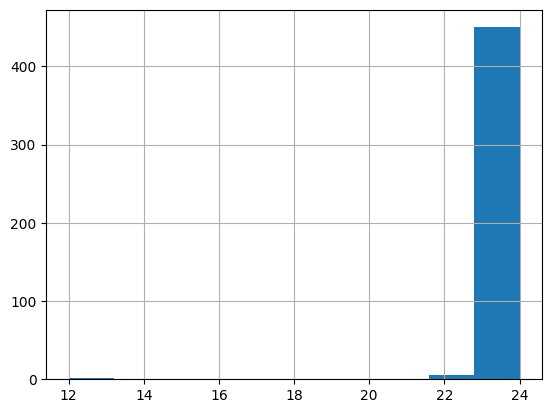

In [13]:
df['datetime'].dt.date.value_counts().hist()

In [14]:
(df['datetime'].dt.date.value_counts()<24).sum() / df['datetime'].dt.date.nunique()


0.09210526315789473

Roughly 9.2% of the days have less than 24 datapoints. We will see later if there is any particular
reason of this but mostly this shouldn’t affect our analysis.

In [15]:
print(f"The data captures information about {df.shape[0]} hours, across{df['datetime'].dt.date.nunique()} days with each datapoint being describedwith {df.shape[1]} different features.")

The data captures information about 10886 hours, across456 days with each datapoint being describedwith 12 different features.


The data captures information about 10886 hours, across 456 days with each
datapoint being described with 12 different features.

In [16]:
df.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count  
count  10886.000000  
mean     191.574132  
std      181.144454  
min        1.000000  
25%       42.000000  
50%      145.000000  
75%      284.000000  
max      977.000000

• It seems that the data has some outliers.

• Casual Rental Bike counts are considerably smaller than registered rental bike counts.

So let’s deep dive now and understand each of these features and how they affect the total Rental
Bike counts.
Let’s see if there is any day-wise or hour-wise trend in counts.


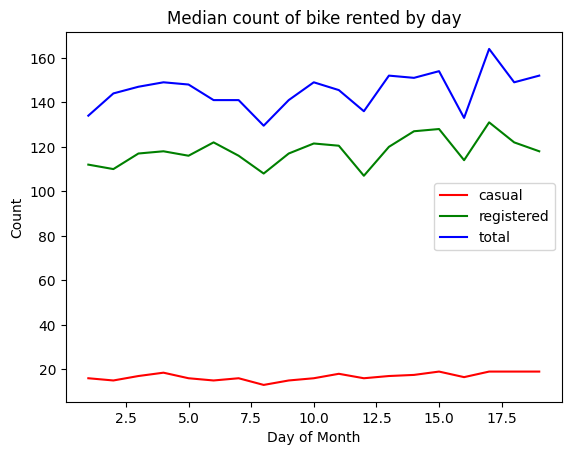

In [17]:
median_casual_rides_day_wise = df.groupby(df['datetime'].dt.day)['casual'].median()
median_registered_rides_day_wise = df.groupby(df['datetime'].dt.day)['registered'].median()
median_total_rides_day_wise = df.groupby(df['datetime'].dt.day)['count'].median()
plt.plot(median_casual_rides_day_wise, color='r', label='casual')
plt.plot(median_registered_rides_day_wise, color='g', label='registered')
plt.plot(median_total_rides_day_wise, color='b', label='total')
plt.title("Median count of bike rented by day")
plt.ylabel('Count')
plt.xlabel('Day of Month')
plt.legend()
plt.show()

• Day-wise counts are almost uniform in a given range, not a high variance.

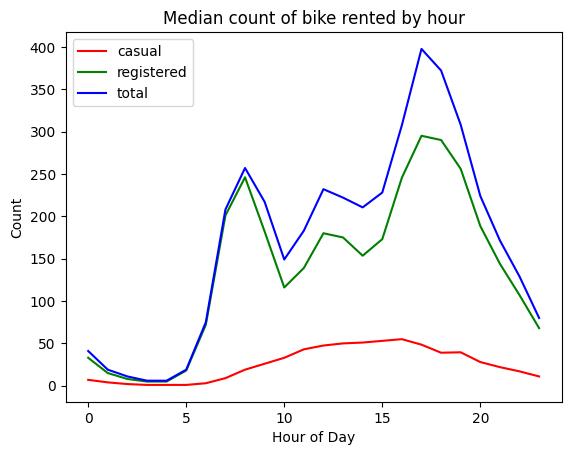

In [40]:
median_casual_rides_hourly = df.groupby(df['datetime'].dt.hour)['casual'].median()
median_registered_rides_hourly = df.groupby(df['datetime'].dt.hour)['registered'].median()
median_total_rides_hourly = df.groupby(df['datetime'].dt.hour)['count'].median()
plt.plot(median_casual_rides_hourly, color='r', label='casual')
plt.plot(median_registered_rides_hourly, color='g', label='registered')
plt.plot(median_total_rides_hourly, color='b', label='total')
plt.title("Median count of bike rented by hour")
plt.ylabel('Count')
plt.xlabel('Hour of Day')
plt.legend()
plt.show()

• Count of rental bikes is higher during day time, specially morning and evening and decreases
during night.

In [41]:
df['datetime'].dt.hour.describe()

count    10585.000000
mean        11.456023
std          6.960447
min          0.000000
25%          5.000000
50%         11.000000
75%         18.000000
max         23.000000
Name: datetime, dtype: float64

In [42]:
# Before moving ahead let's create two more feature, they will be useful in the analysis
cut_labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night']
cut_bins = [-1, 6, 12, 17, 22, 24]
df['time_of_day'] = pd.cut(df['datetime'].dt.hour, bins=cut_bins,labels=cut_labels, ordered=False)
11
df['time_of_day'].isna().sum() # Just checking if all values were labelled correctly or not

0

In [43]:
# Let's list out categorical and conitnuous features separately.
categorical_cols = ['season','holiday', 'workingday', 'weather', 'time_of_day']
continuous_cols = ['temp', 'atemp', 'humidity', 'windspeed', 'casual','registered', 'count']

Let’s try to visualize patterns in data using helper functions we defined

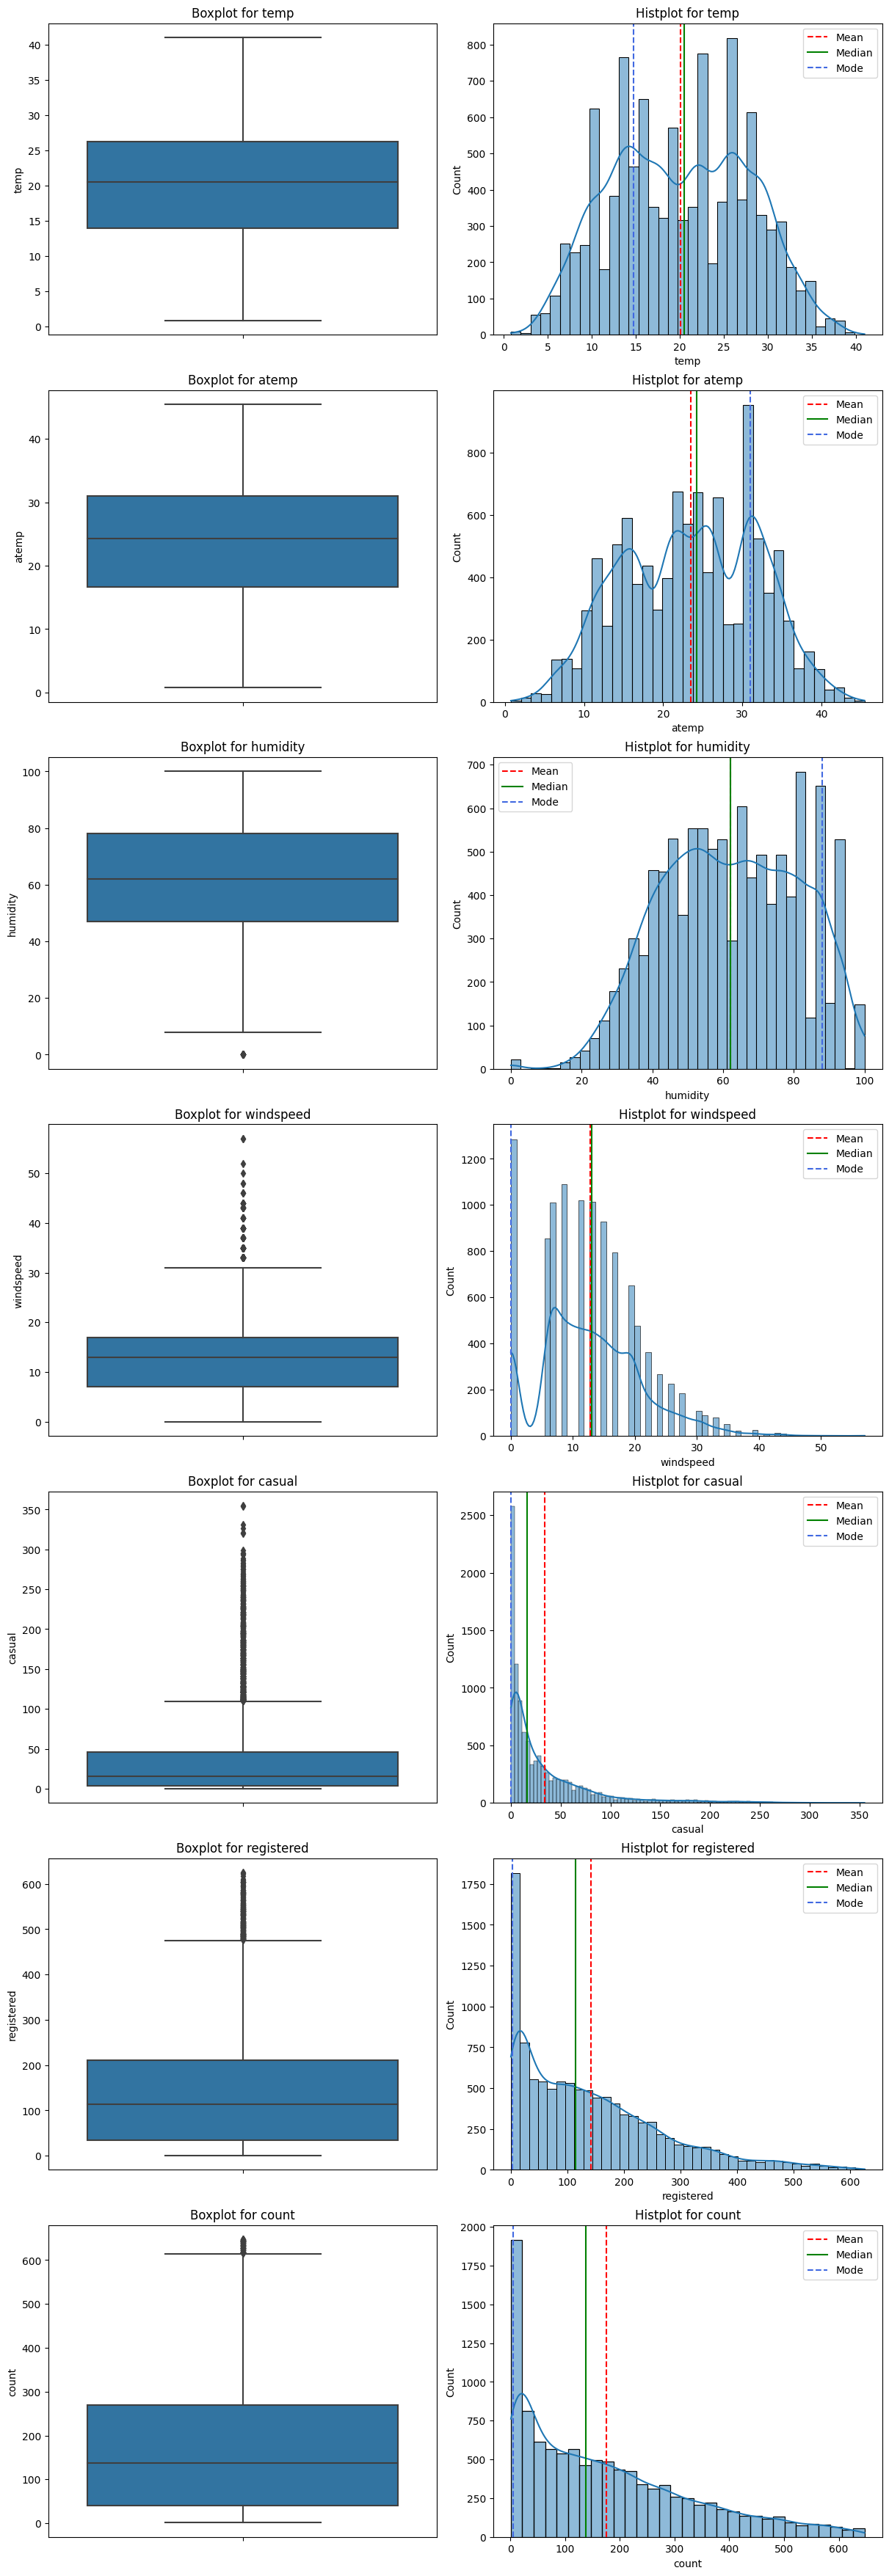

In [44]:
# Analyzing Distributions of Continuous features, looking for outliers
univariate_analysis(data=df, features=continuous_cols,type_of_feature='continuous', width = 12, height = 5)

• Humidity, windspeed, casual, registered and total counts have some outliers.

In [49]:
# Let's remove these outliers
df_without_outliers, outliers = remove_outliers(data=df,features=continuous_cols, method='iqr')

5.4511890541861225% data detected as outlier.


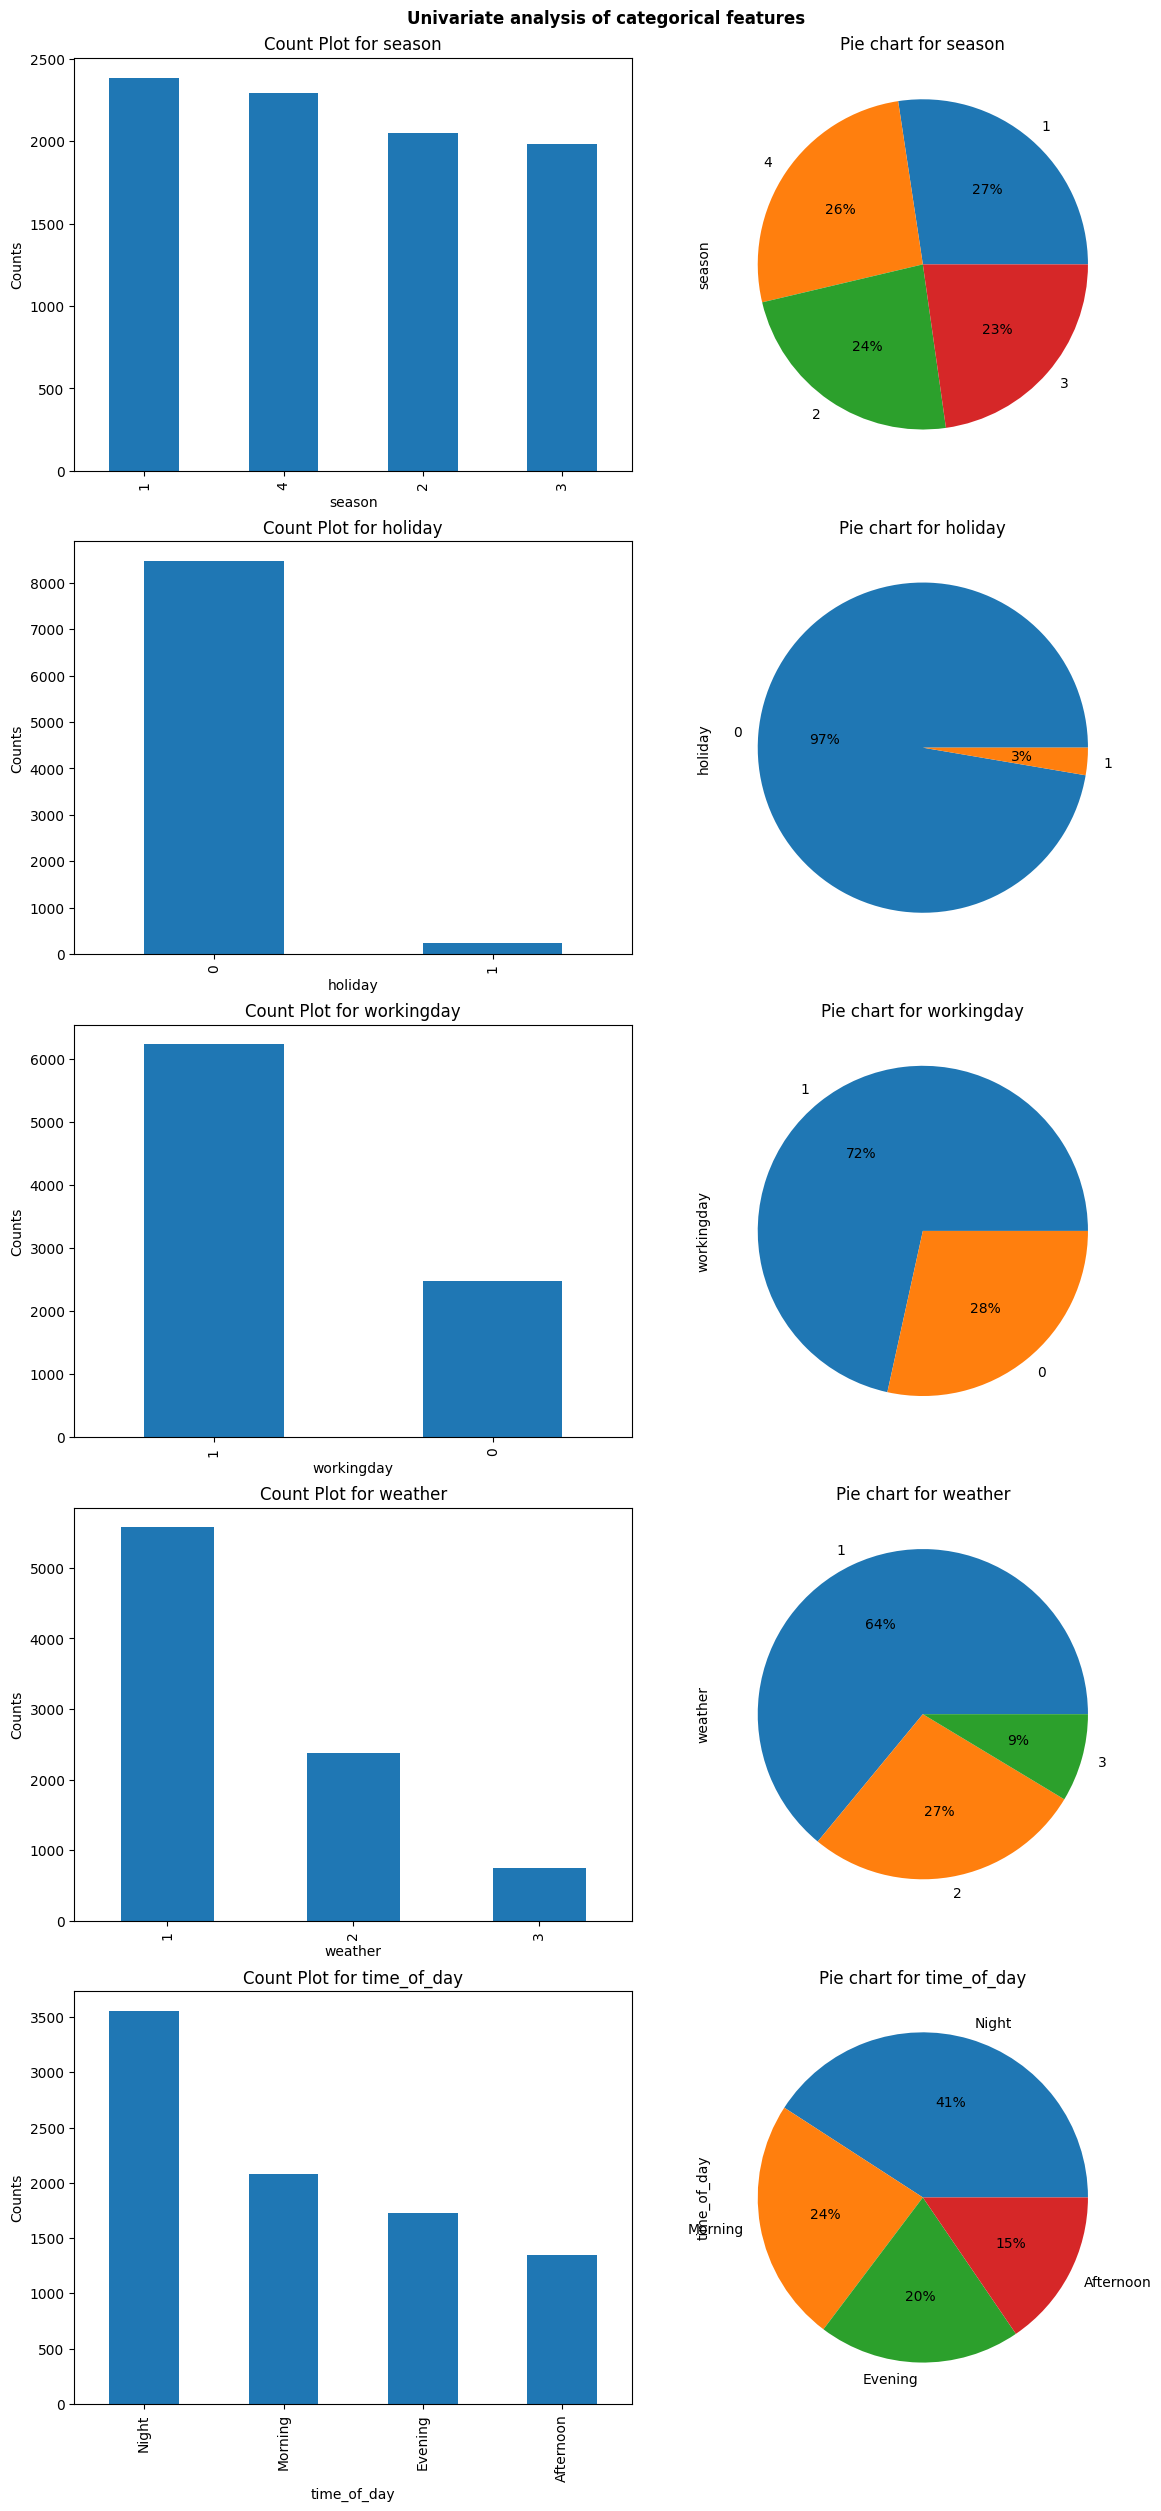

In [50]:
univariate_analysis(data=df, features=categorical_cols,type_of_feature='categorical', width = 12, height = 5)

• Interesting thing to observe here is that we do not have any data points for extreme weather
(4) conditions.

• Apart from that it’s good to see that our dataset is almost equally distributed across seasons.

• For remaining features like holiday, workingday distributions makes sense, as per intuition.

In [51]:
df[df['weather']==4]

Empty DataFrame
Columns: [datetime, season, holiday, workingday, weather, temp, atemp, humidity, windspeed, casual, registered, count, time_of_day]
Index: []

NO record. Can be removed from our analysis.

In [52]:
df = df[df['weather']!=4]

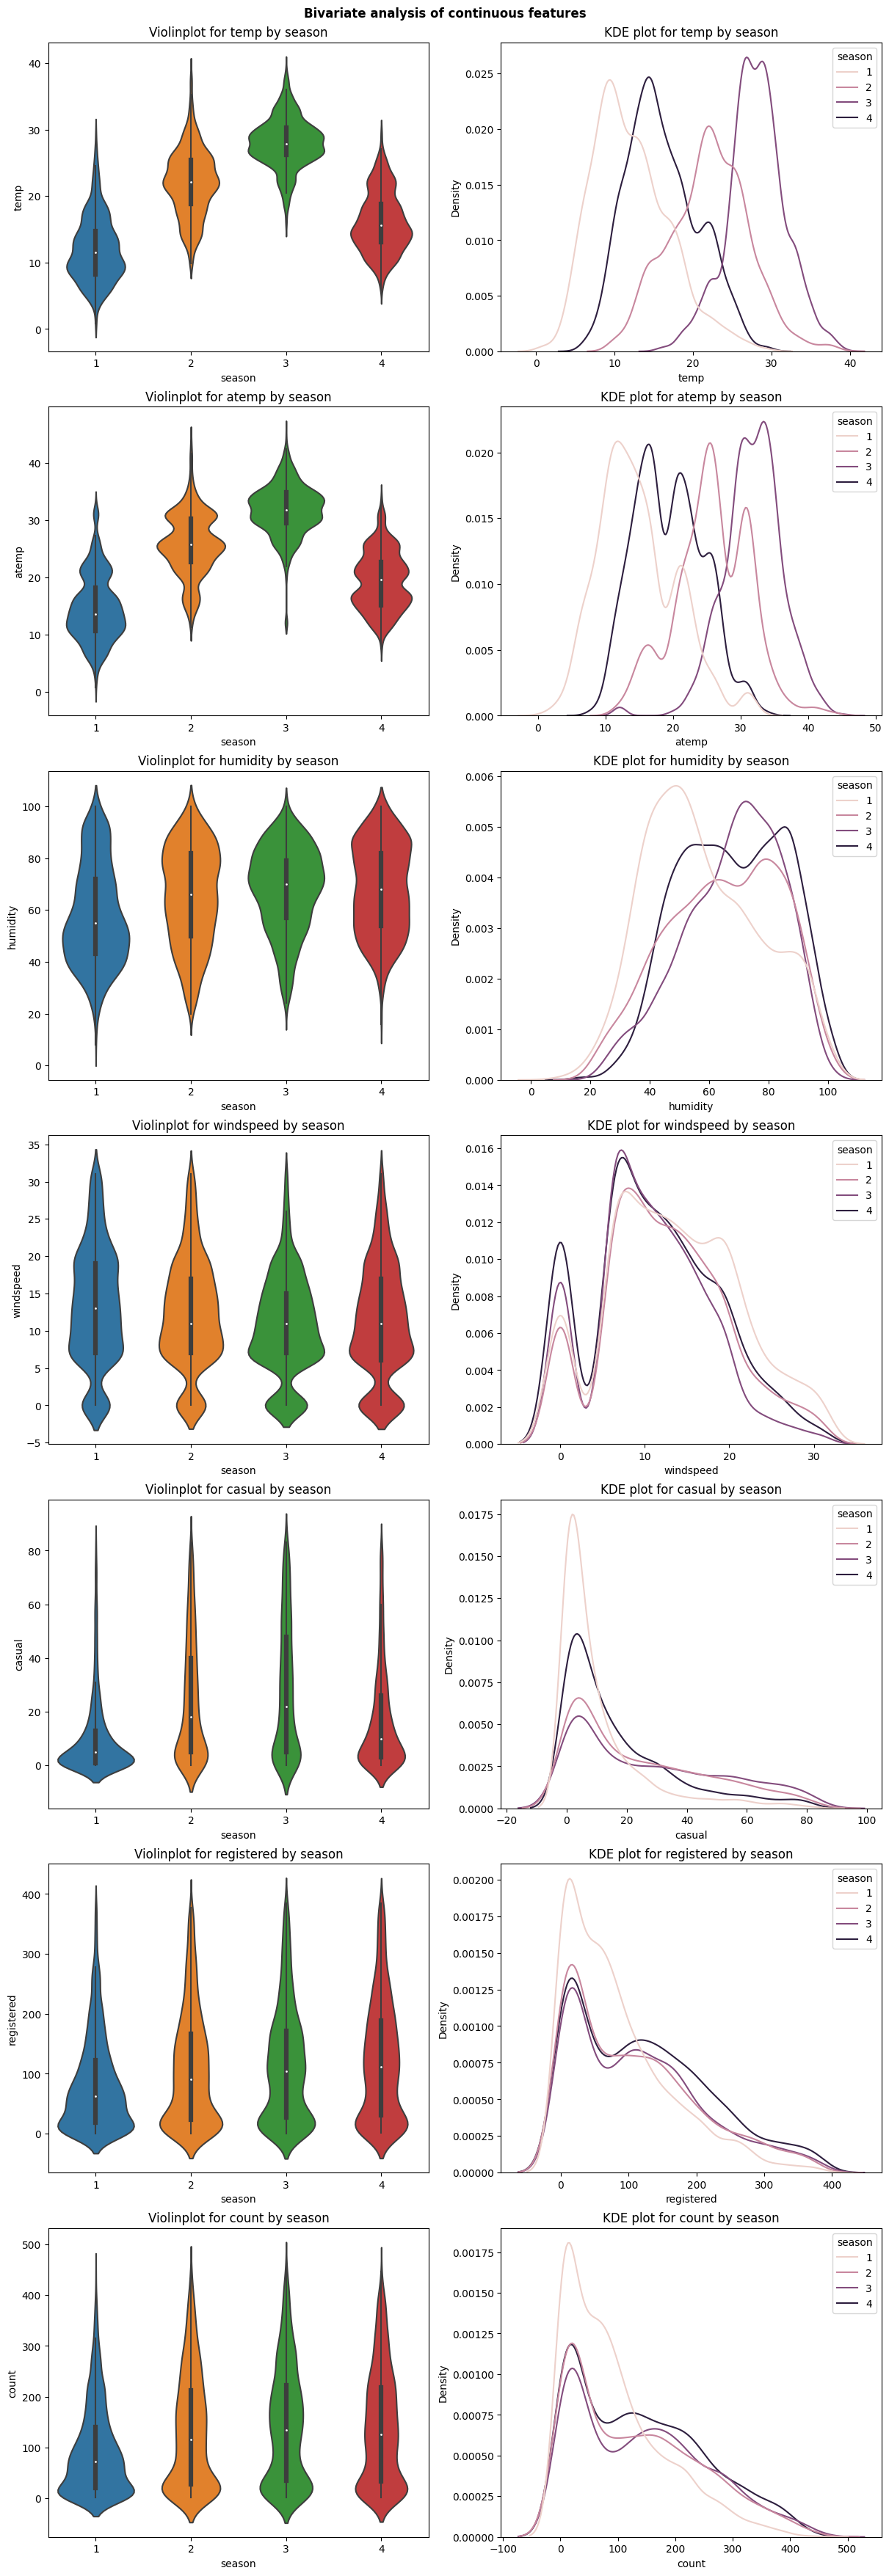

In [53]:
# By season
# Bivariate Analysis
bivariate_analysis(data=df, features=continuous_cols,type_of_feature='continuous', group_by='season', width = 12, height = 5)

• temp, humidity and windspeed as clearly related to season, which is intuitive.

• It is evident that casual, registered and thus, total rental bike counts are affected by season.
– We have more casual biker in fall and summer as compared to winter and sprint. (fall> summer > winter > spring)
– Count of registered bikers is lowest for spring, while it slowly increases from summer to
winter (spring < summer < fall < winter) - which reflects in the total counts as well.

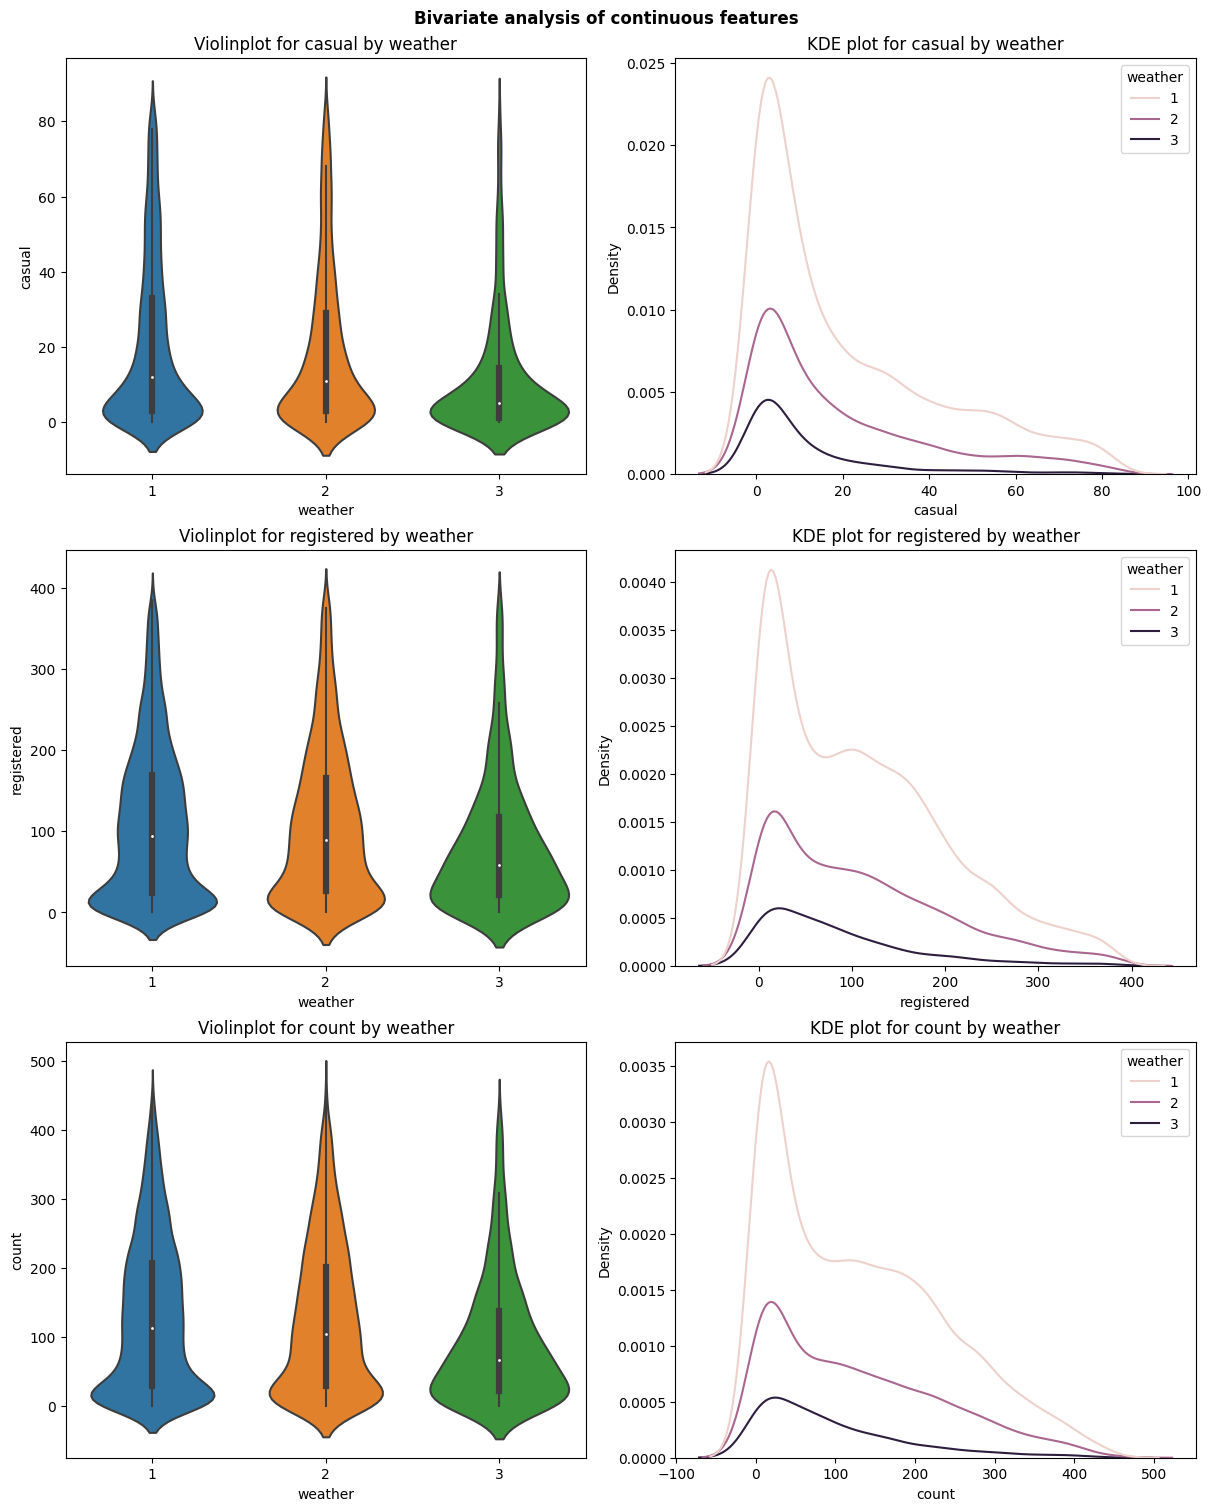

In [54]:
# By weather
bivariate_analysis(data=df, features=['casual', 'registered', 'count'],type_of_feature='continuous', group_by='weather', width = 12, height = 5)

People hire more rental bikes in pleasant and clear weather.

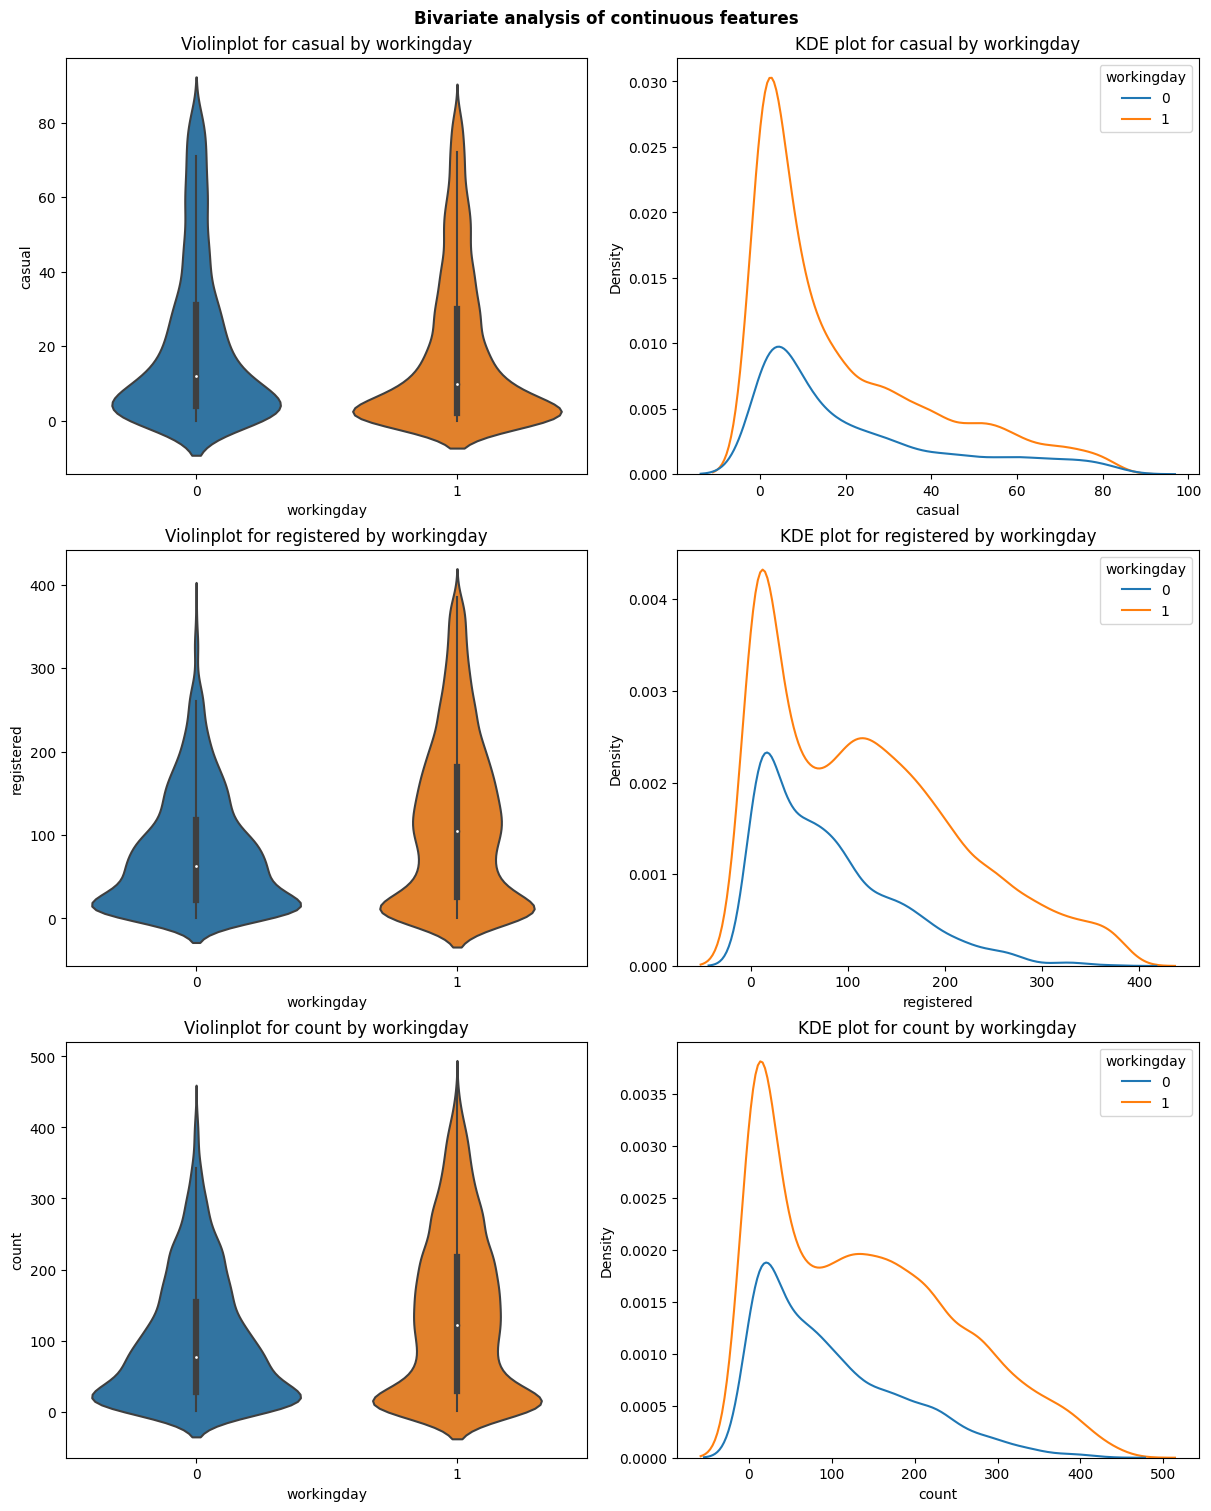

In [55]:
# By workingday
bivariate_analysis(data=df, features=['casual', 'registered', 'count'],type_of_feature='continuous', group_by='workingday', width = 12, height = 5)

• People are hire more rental bikes on workingday, probably for commuting to work, as compared to other days.

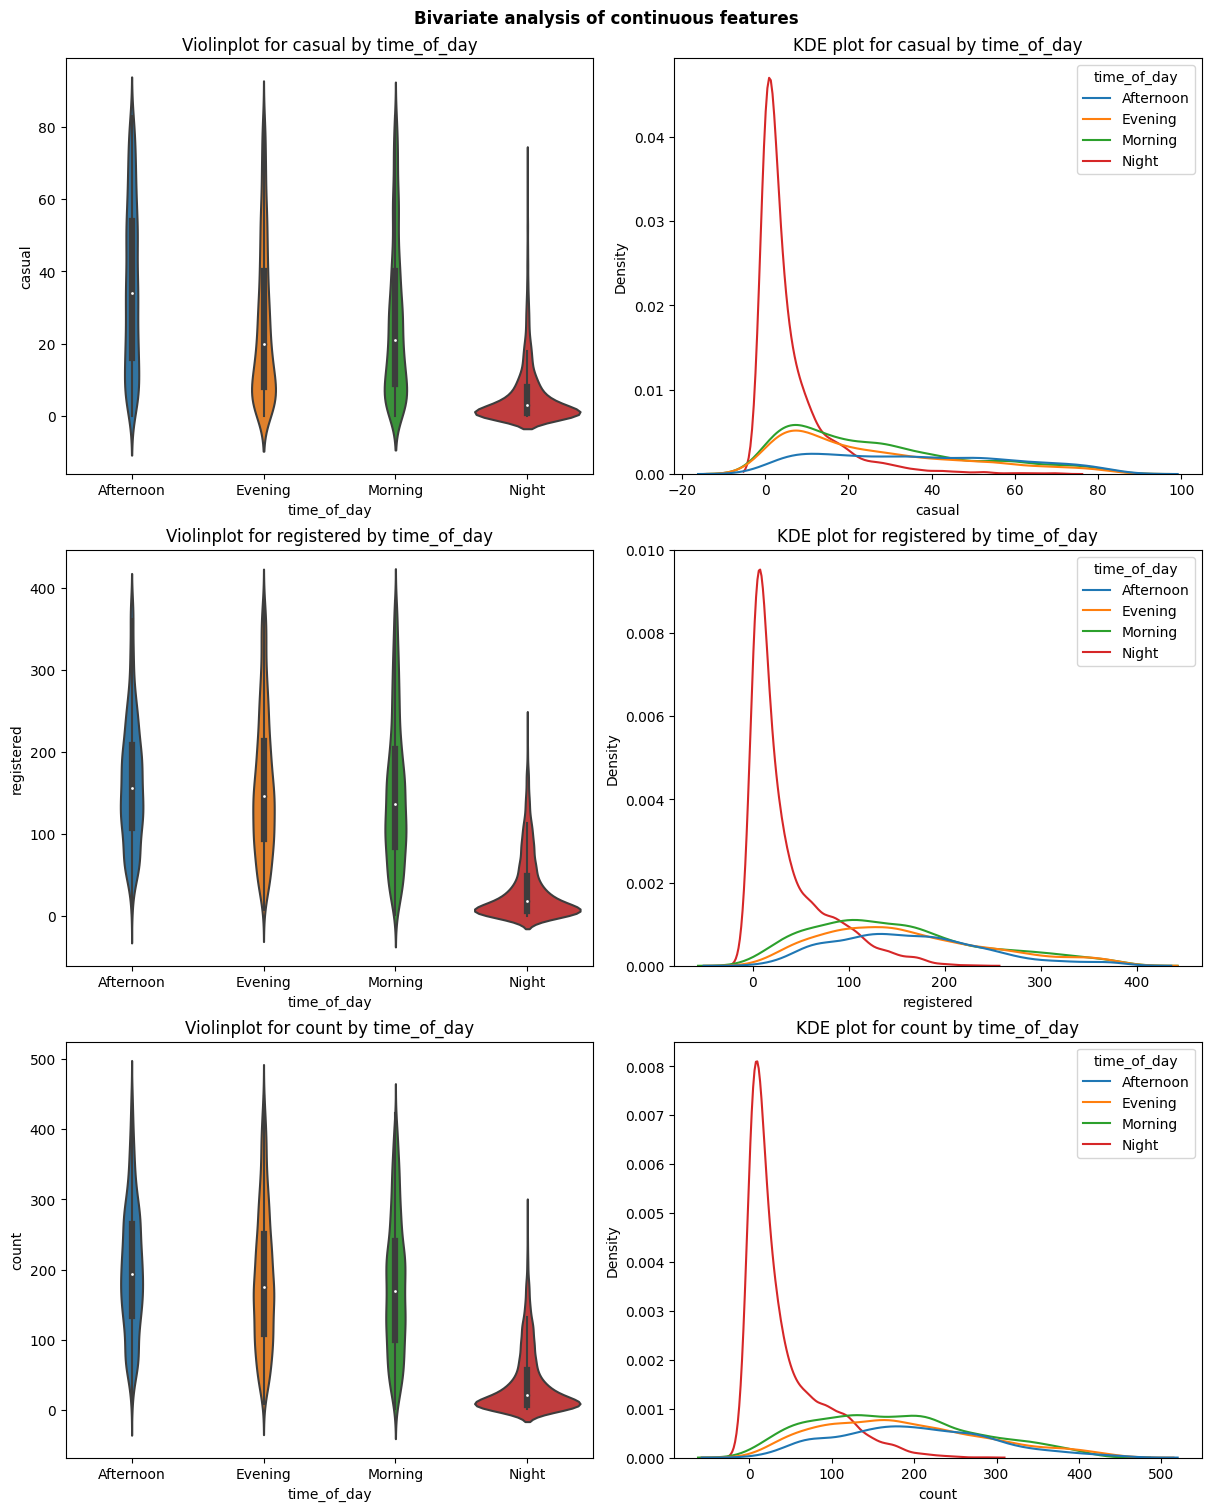

In [56]:
#By Time of Day
bivariate_analysis(data=df, features=['casual', 'registered', 'count'],type_of_feature='continuous', group_by='time_of_day', width = 12, height = 5)

People rent bikes generally in day time

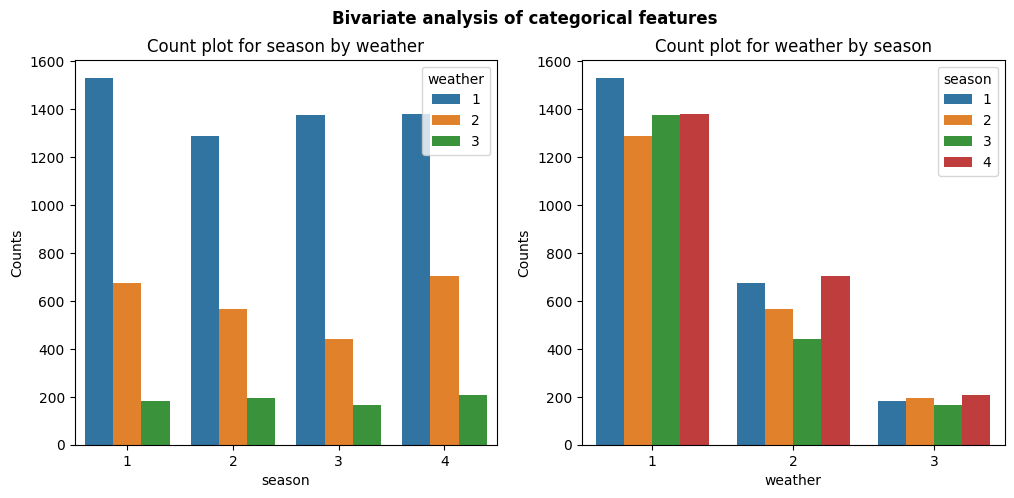

In [57]:
# Just out of curiosity, let's check how weather and season are related
bivariate_analysis(data=df, features=['season'], type_of_feature='categorical',group_by='weather', width = 12, height = 5)

• If observe very carefully, weather 2 seems to have some realtionship with season as it happens
compartively less time for season 3 and 2.

• Otherwise, Weather seems to have very similar trend across all seasons.

Looking into marginal probabilities of count by weather, workingday, time_of_day

In [58]:
df['count'].describe()

count    8707.000000
mean      126.562306
std       107.292676
min         1.000000
25%        28.000000
50%       106.000000
75%       202.000000
max       455.000000
Name: count, dtype: float64

In [59]:
cut_labels = ['Low', 'Medium', 'High']
cut_bins = [-1, 100, 250, 600]
df['count_bins'] = pd.cut(df['count'], bins=cut_bins, labels=cut_labels)

In [60]:
pd.crosstab(index=df['count_bins'], columns=df['weather'], normalize=True,margins=True)

weather            1         2         3       All
count_bins                                        
Low         0.298151  0.132537  0.054898  0.485586
Medium      0.239692  0.099116  0.024693  0.363501
High        0.102331  0.041920  0.006661  0.150913
All         0.640175  0.273573  0.086252  1.000000

• Probability of renting a bike is higher when weather is pleasant.

• Low count of rented bike generally has a higher probability.


In [61]:
pd.crosstab(index=df['count_bins'], columns=df['workingday'], normalize=True,margins=True)

workingday         0         1       All
count_bins                              
Low         0.168945  0.316642  0.485586
Medium      0.095670  0.267830  0.363501
High        0.019869  0.131044  0.150913
All         0.284484  0.715516  1.000000

• Probability of renting a bike on a workingday is very high when compared to other days.

In [62]:
pd.crosstab(index=df['count_bins'], columns=df['time_of_day'], normalize=True,margins=True)


time_of_day  Afternoon   Evening   Morning     Night       All
count_bins                                                    
Low           0.024233  0.042954  0.060067  0.358332  0.485586
Medium        0.085104  0.105203  0.123234  0.049960  0.363501
High          0.045366  0.049960  0.055358  0.000230  0.150913
All           0.154703  0.198116  0.238659  0.408522  1.000000

• During night, count of rented bike is more likely to be low.

Marginal Probability of weather by season.

In [63]:
pd.crosstab(index=df['weather'], columns=df['season'], normalize=True,margins=True)


season          1         2         3         4       All
weather                                                  
1        0.175606  0.148042  0.157919  0.158608  0.640175
2        0.077294  0.065120  0.050534  0.080625  0.273573
3        0.021018  0.022281  0.019180  0.023774  0.086252
All      0.273918  0.235443  0.227633  0.263007  1.000000

• Weather conditions are equally likely across seasons.

Let’s now do some multivariate analysis

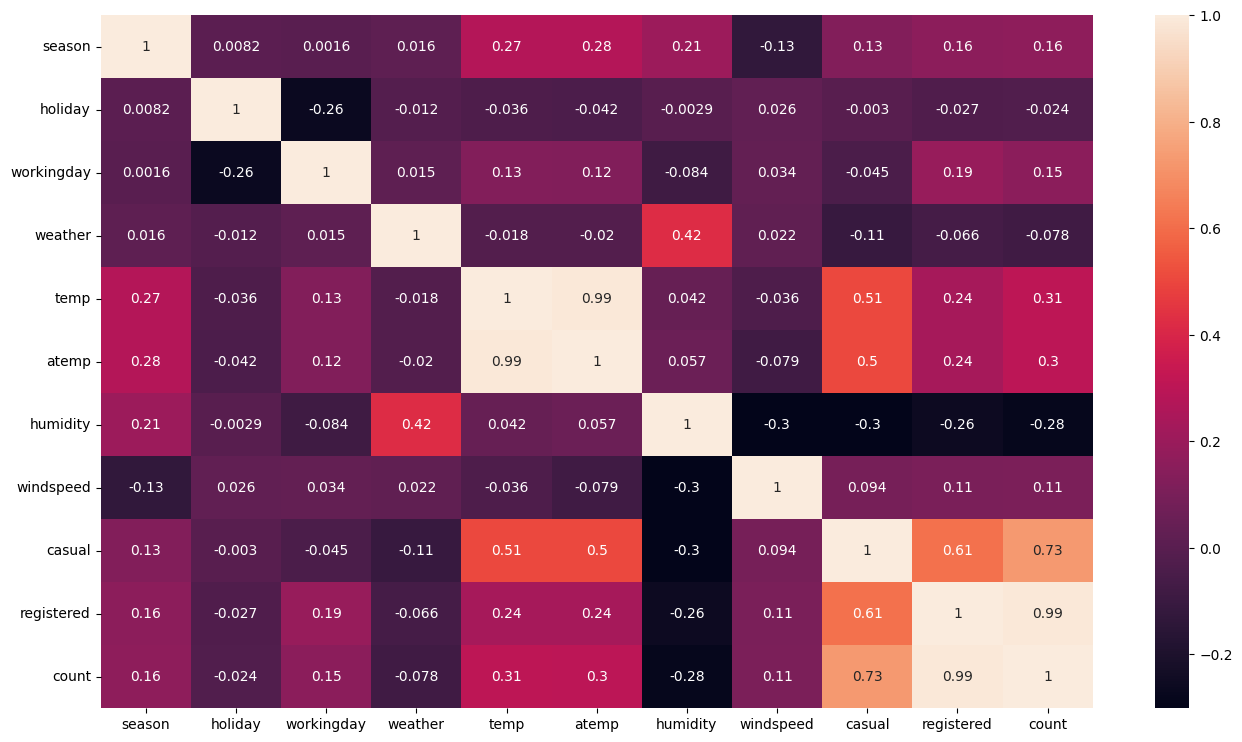

In [64]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), annot=True)
plt.show()

• temp positively affects casual, registered, total counts.

• humidity negatively affects casual, registered, total counts i.e; lower the humidity better the
rental bike counts.

• Weather has a negative correlation with counts i.e; better the weather higher the counts.

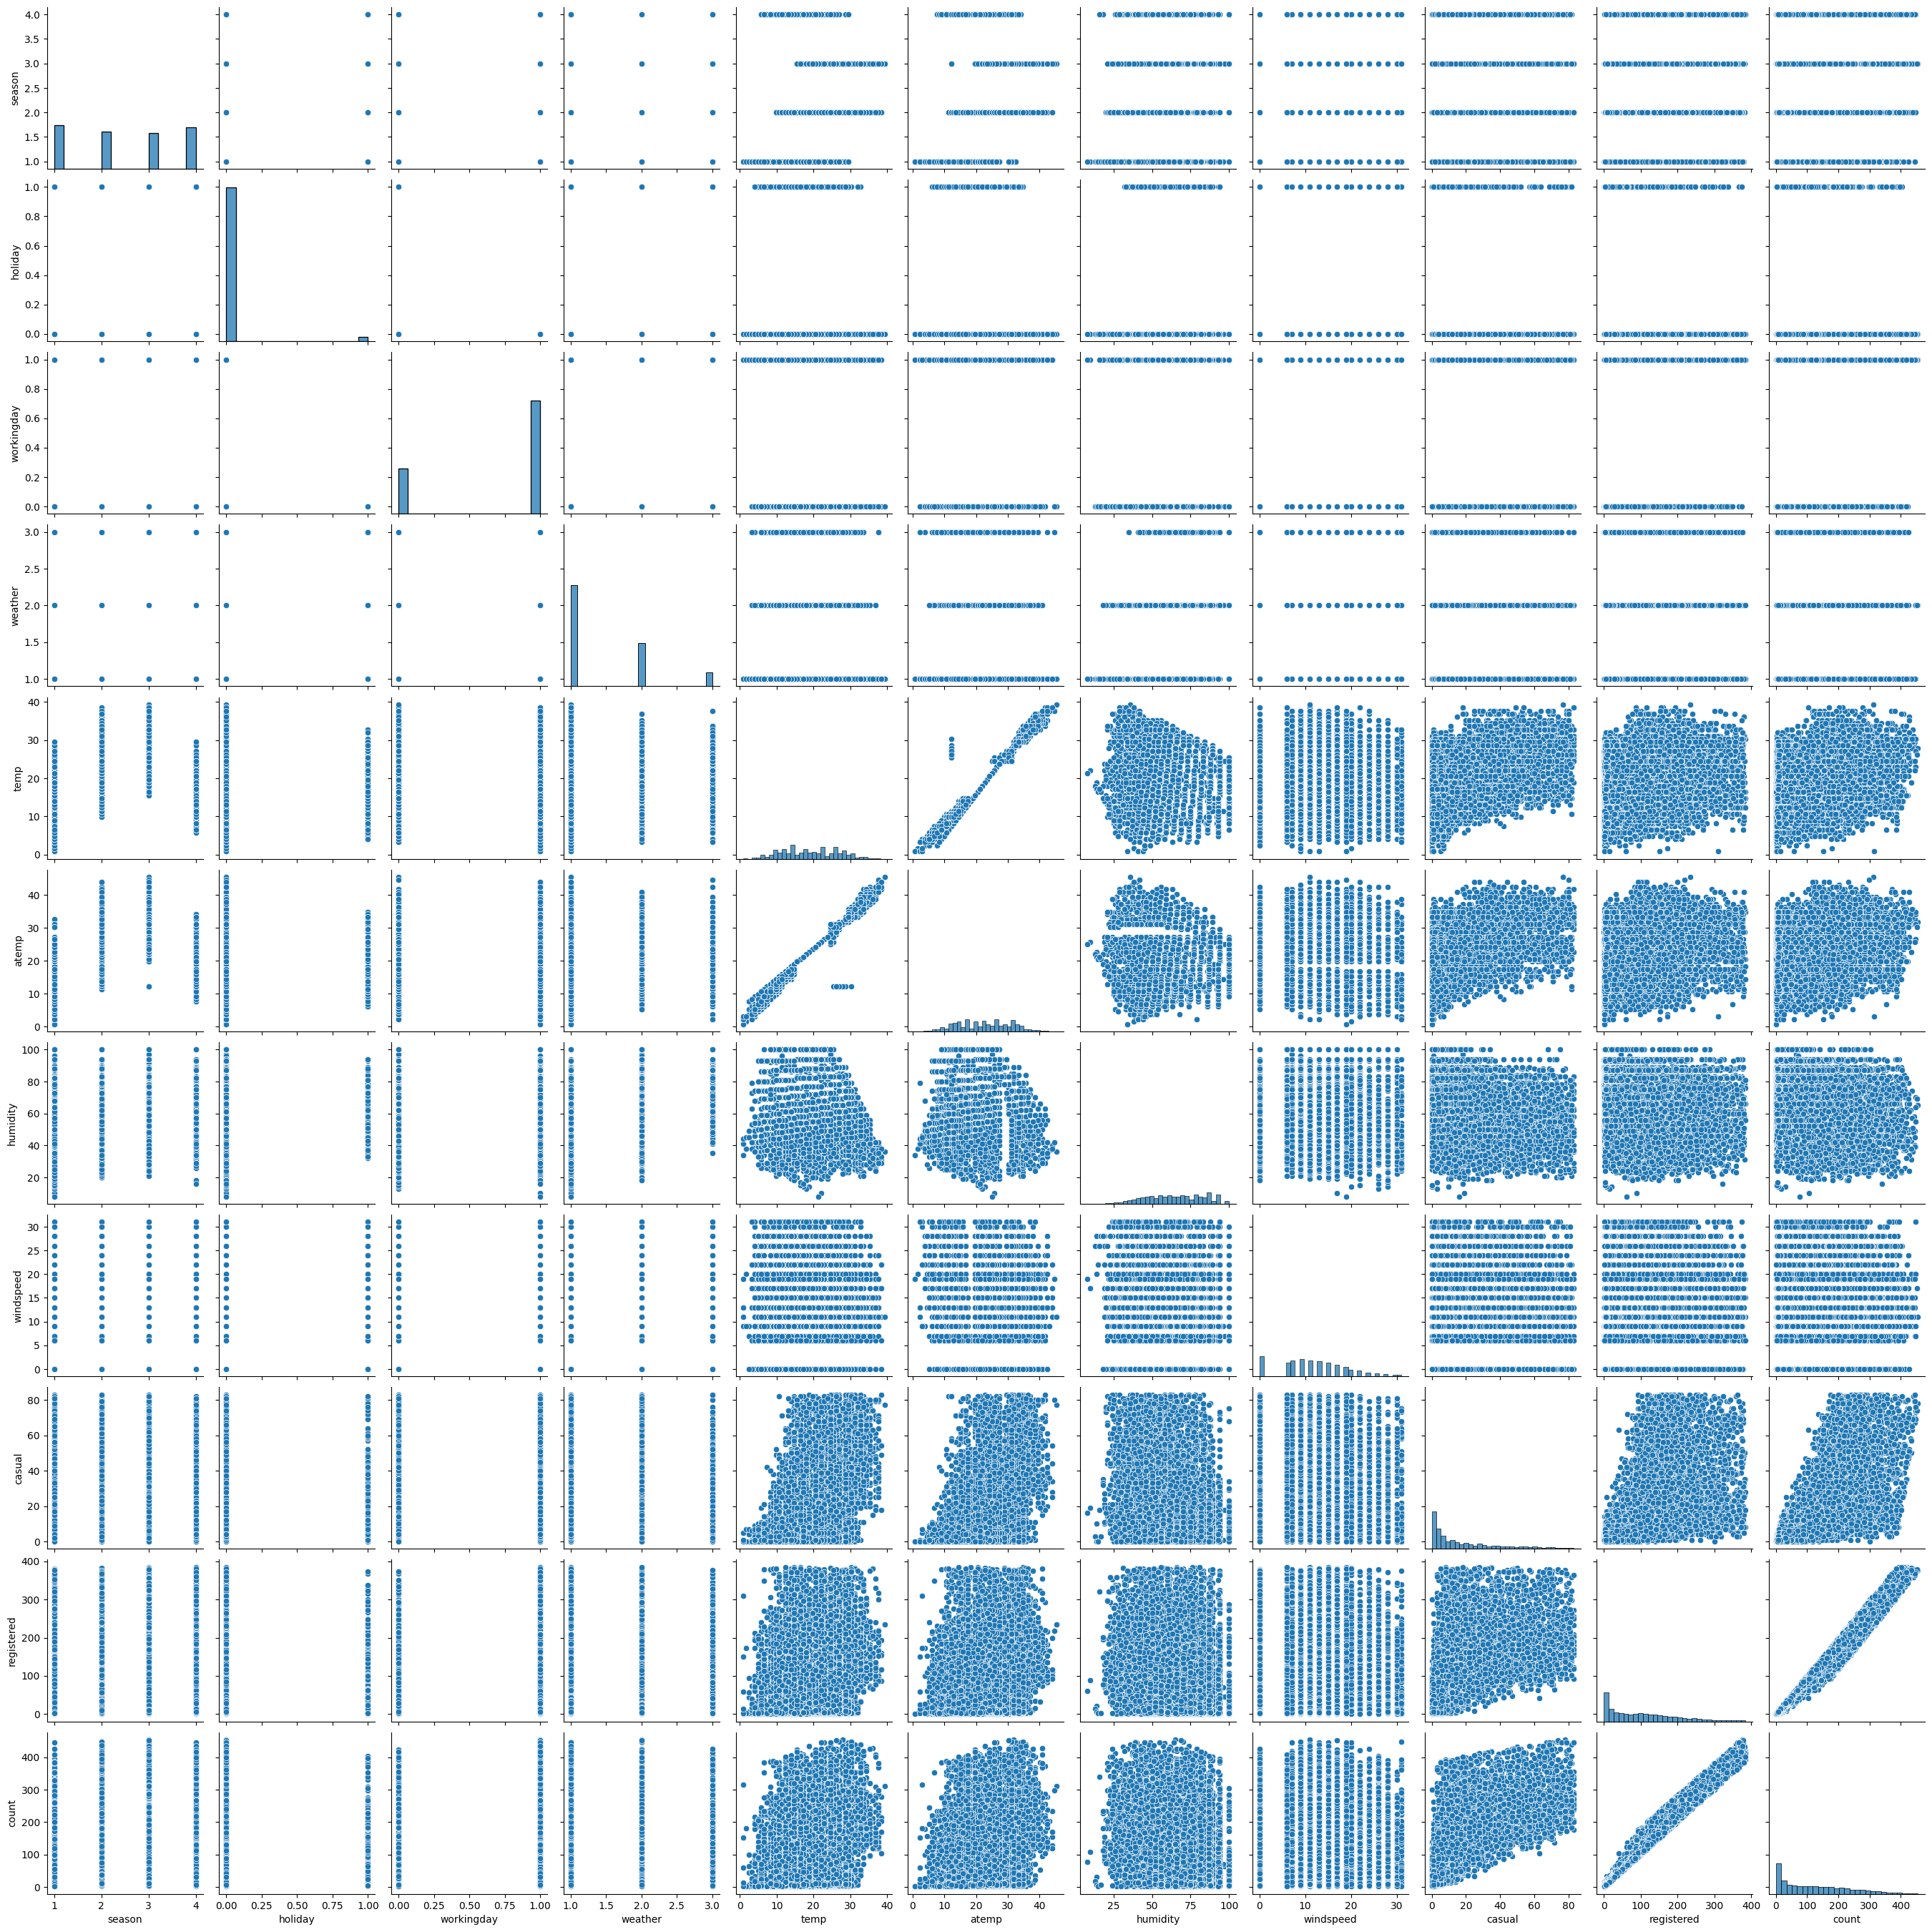

In [65]:
sns.pairplot(data=df)

##1.2 

**Let’s try to validate these relationships with Hypoythesis Testing**
Defining helper functions

In [66]:
def qqplot(data):
  '''
  This function plot qqplot for visual test of normality for input data
  Parameters:
  data : Data under analysis.
  Returns:
  None
  '''
  stats.probplot(data, dist="norm", plot=plt)
  plt.show()

In [68]:
def shapiro_wilk_test(data, alpha):
  '''
  This function does statistical test of normality for input data
  H0 : Data is normal
  Ha : Data is not normal
  Parameters:
  data : Data under analysis.
  alpha: Significance level.
  Returns:
  None
  '''
  w_stats, p_value = stats.shapiro(data)
  print("p-value:", p_value)
  if p_value > alpha :
    print("We do not reject the null hypothesis")
  else:
    print("Reject the Null Hypothesis")

In [69]:
def levene_test(sample1, sample2, center, alpha):
  '''
  This function does statistical test of assess the equality of variance
  between two different samples
  H0 : variance among groups is equal
  Ha : variance among groups is not equal
  Parameters:
  sample1, sample2 : Samples under analysis.
  center : {'mean', 'median', 'trimmed'},
  Which function of the data to use in the test.
  alpha: Significance level.
  Returns:
  None
  '''
  w_stats, p_value = stats.levene(sample1, sample2, center = center)
  print("p-value:", p_value)
  if p_value > alpha :
    print("We do not reject the null hypothesis")
  else:
    print("Reject the Null Hypothesis")


**Question 1 - Does working day has a affect on total counts of rented cycles?** 

H0 : The
count of rented cycle is equal on Working Day and Weekend.

Ha : The count of rented cycle is not equal on Working Day and Weekend.

We will conduct a independent t-test with 1. Two sample 2. Two Tailed 3. Independent Samples.

Let’s take alpha to be = 0.05

First we will verify the assumptions for t-test

• The samples are drawn from a Gaussian distribution.

• The size of each sample is approximately equal.

• The samples have the same variance.

and then perform the actual test

In [70]:
# Gathering observations
workingday = df.loc[df['workingday']==1, 'count']
weekend = df.loc[df['workingday']==0, 'count']

<Axes: xlabel='count', ylabel='Density'>

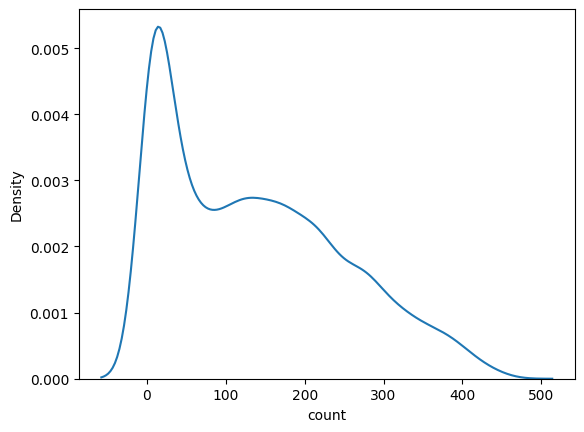

In [71]:
# Let's check the distributions first.
sns.kdeplot(x=workingday)

<Axes: xlabel='count', ylabel='Density'>

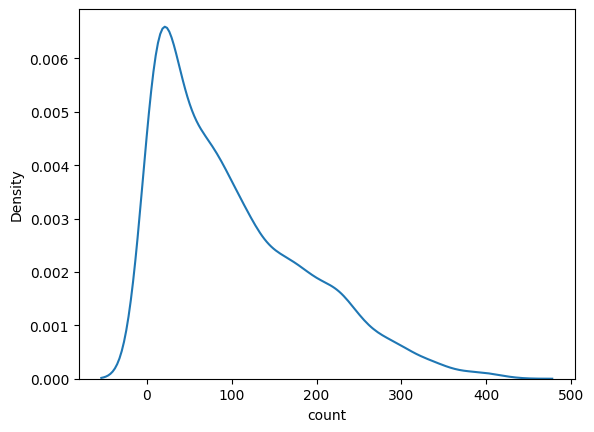

In [72]:
sns.kdeplot(x=weekend)

We can clearly see that these distributions are postively skewed. Let’s try to tranform this to close
to gaussian.

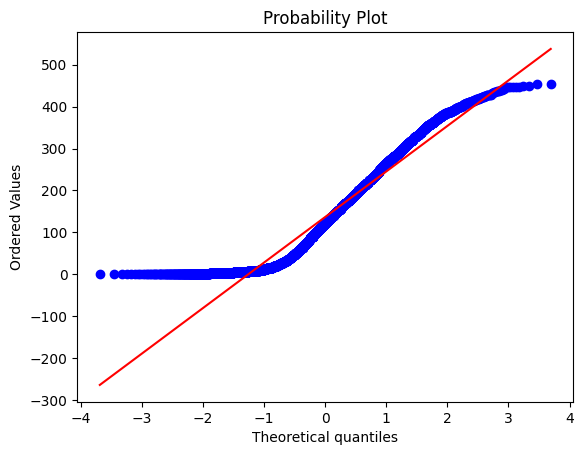

In [73]:
# Let's see how QQ plot is coming up
qqplot(workingday)

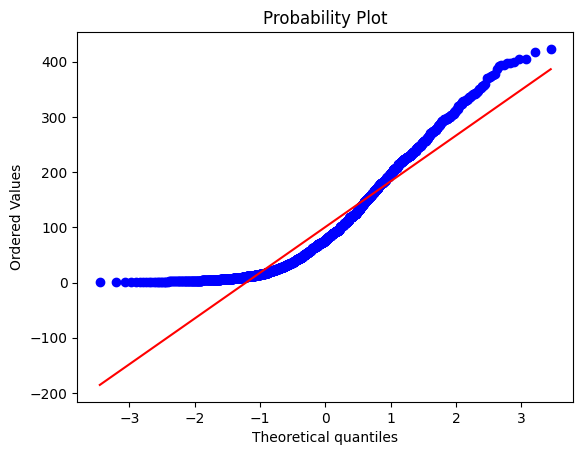

In [74]:
qqplot(weekend)

We can see QQ Plot is not coming up good.

In [75]:
# Let's also do statistical test - Shapiro Wilk Test
# For Working day
shapiro_wilk_test(workingday, 0.05)

p-value: 0.0
Reject the Null Hypothesis


In [76]:
# For Weekend
shapiro_wilk_test(weekend, 0.05)

p-value: 2.4160127619210695e-37
Reject the Null Hypothesis


Shapiro Wilk Test says it is probably not a gaussian dist since p-values are less than 0.05 for both
samples

<Axes: xlabel='count', ylabel='Density'>

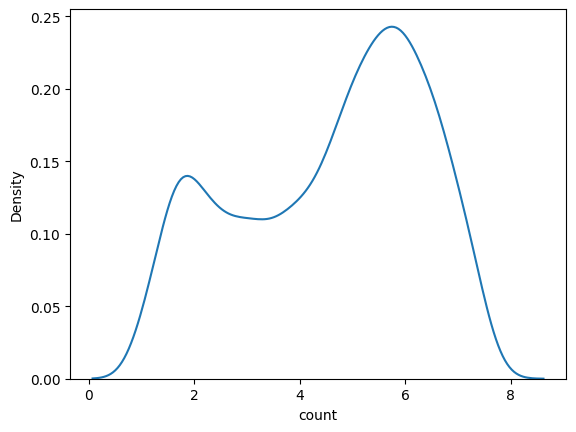

In [77]:
# transforming the distributions by cube root function
sns.kdeplot(x=pow(workingday, 1/3))

<Axes: xlabel='count', ylabel='Density'>

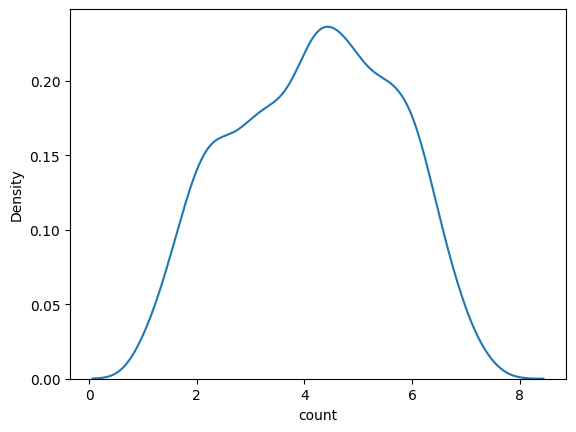

In [78]:
sns.kdeplot(x=pow(weekend, 1/3))

This looks better than before

In [79]:
workingday = pow(workingday, 1/3)
weekend = pow(weekend, 1/3)

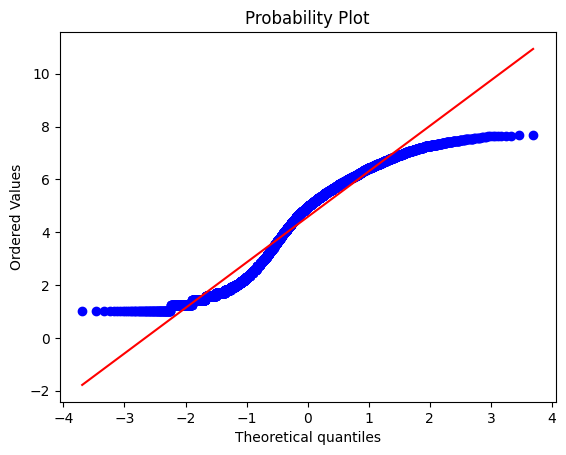

In [80]:
# Let's verify with the help of QQ plot
stats.probplot(workingday, dist="norm", plot=plt)
plt.show()

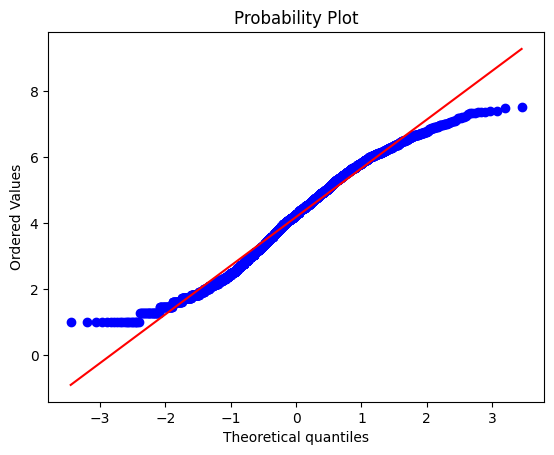

In [81]:
# Let's verify with the help of QQ plot
stats.probplot(weekend, dist="norm", plot=plt)
plt.show()

Even after transformation, QQ plot has not improved.

In [82]:
# Let's also do statistical test - Shapiro Wilk Test
# For Working day
shapiro_wilk_test(workingday, 0.05)

p-value: 1.0411647589933391e-42
Reject the Null Hypothesis


In [83]:
# For Weekend
shapiro_wilk_test(weekend, 0.05)

p-value: 6.615562650940357e-18
Reject the Null Hypothesis


In [84]:
# let's check size of each sample
workingday.shape, weekend.shape

((6230,), (2477,))

In [85]:
# let's check variance if the variance are equal
# Levene's test of variance
levene_test(workingday, weekend, center='mean', alpha=0.05)

p-value: 2.128426735629442e-36
Reject the Null Hypothesis


Levene’s test says that the variance of these two samples are not equal.

We can see all the assumptions are failing.

Let’s anyways do the two-sided, independent t-test. (Performing final test)


In [87]:
alpha = 0.05
w_stats, p_value = stats.ttest_ind(workingday, weekend)
print("p-value:", p_value)
if p_value > alpha :
  print("We do not reject the null hypothesis")
else:
  print("Reject the Null Hypothesis")

p-value: 5.470670848962049e-23
Reject the Null Hypothesis


2 Sample t-test of independent samples concluded in rejecting the null hypothesis i.e; we have
enough evidence to say that probably Working day has an affect on number of electric cycles
rented.

**Question 2 - Is no. of cycles rented is similar in different seasons?** H0 : The count of
rented cycle is equal across seasons.

Ha : The count of rented cycle is not equal across seasons.
As, there are multiple group We will conduct a ANOVA Test.

Let’s take alpha to be = 0.05

First we will verify the assumptions for ANOVA

• The samples are drawn from a Gaussian distribution.

• The size of each sample is approximately equal.

• The samples have the same variance.
and then perform the actual test.

In [88]:
# Gathering observations
season1 = df.loc[df['season']==1, 'count']
season2 = df.loc[df['season']==2, 'count']
season3 = df.loc[df['season']==3, 'count']
season4 = df.loc[df['season']==4, 'count']

<Axes: xlabel='count', ylabel='Density'>

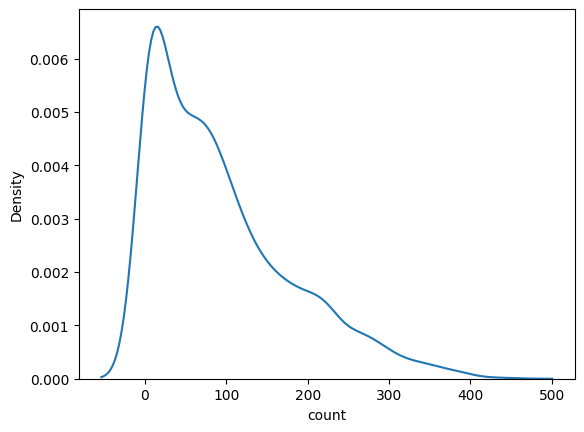

In [89]:
# Let's check the distributions first.
sns.kdeplot(x=season1)

<Axes: xlabel='count', ylabel='Density'>

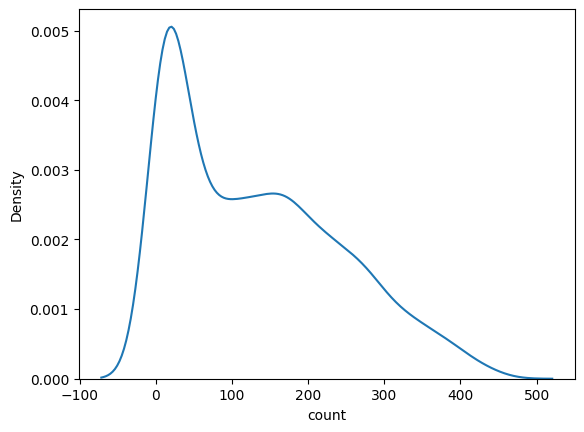

In [90]:
sns.kdeplot(x=season2)

<Axes: xlabel='count', ylabel='Density'>

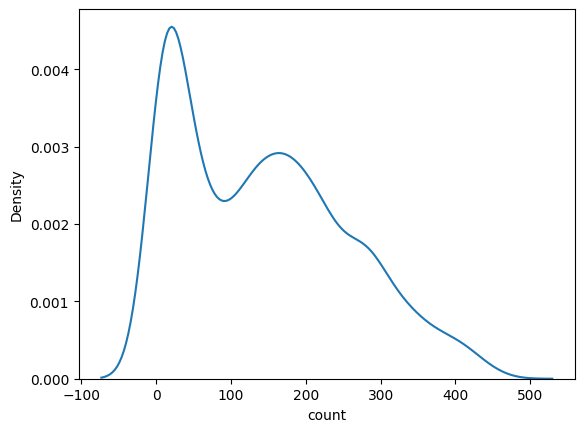

In [91]:
sns.kdeplot(x=season3)

<Axes: xlabel='count', ylabel='Density'>

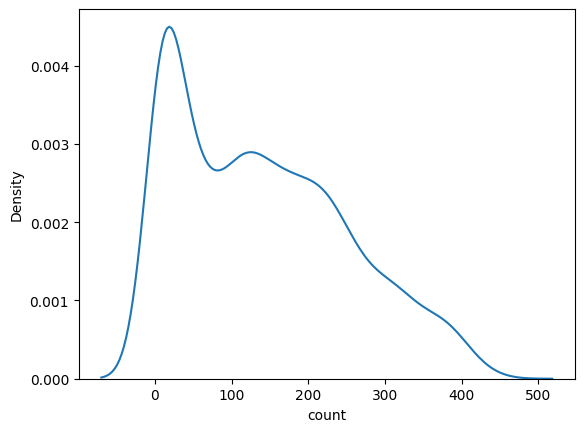

In [92]:
sns.kdeplot(x=season4)

Similar to what saw earlier, these distributions are also postively skewed.

Let’s try to tranform
this to close to gaussian

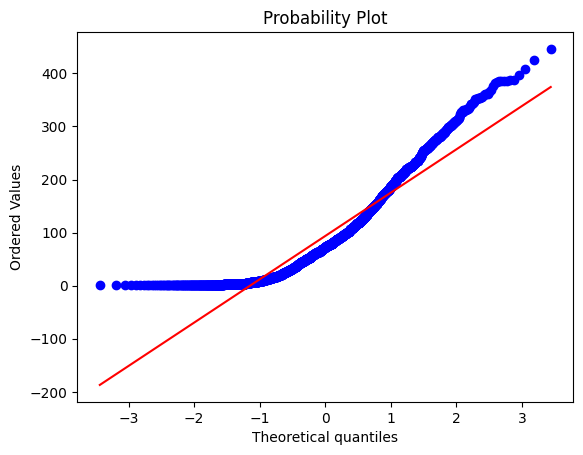

In [93]:
# Let's see how QQ plot is coming up
qqplot(season1)

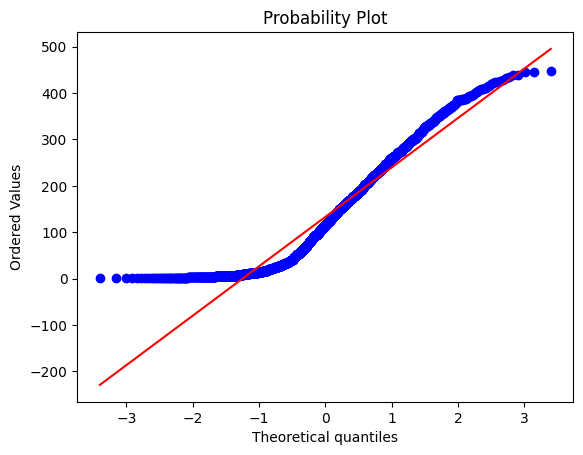

In [94]:
qqplot(season2)

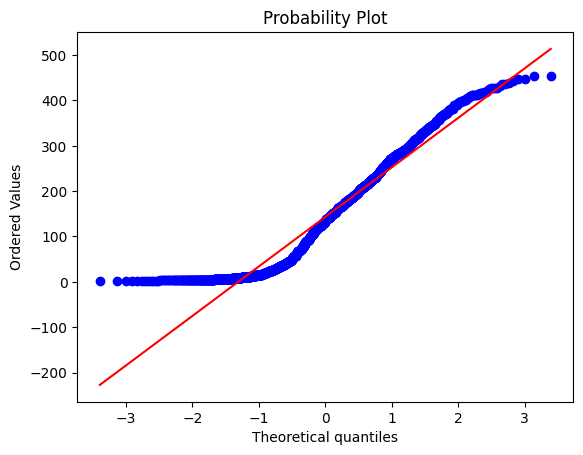

In [95]:
qqplot(season3)

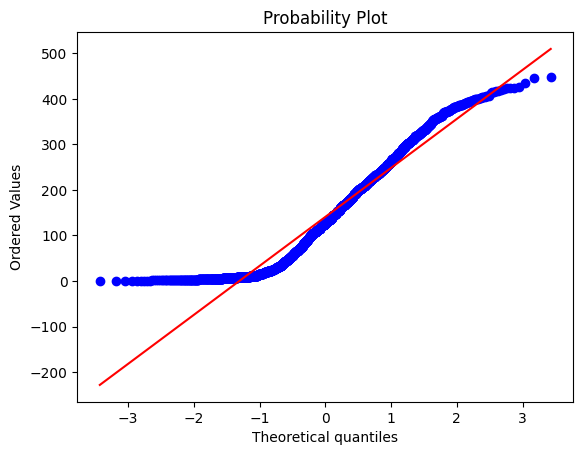

In [96]:
qqplot(season4)

Again, We can see QQ Plot is not coming up good.

In [97]:
# Let's also do statistical test - Shapiro Wilk Test
i = 1
for s in [season1, season2, season3, season4]:
  print(f"## For season {i} ##")
  shapiro_wilk_test(season1, 0.05)
  print()
  i+=1

## For season 1 ##
p-value: 2.557873884580255e-38
Reject the Null Hypothesis

## For season 2 ##
p-value: 2.557873884580255e-38
Reject the Null Hypothesis

## For season 3 ##
p-value: 2.557873884580255e-38
Reject the Null Hypothesis

## For season 4 ##
p-value: 2.557873884580255e-38
Reject the Null Hypothesis



Shapiro Wilk Test says it is probably not a gaussian dist since p-values are less than 0.05 for any
season.

In [98]:
stats.boxcox(season1)

(array([ 4.52961506,  7.19394215,  6.46926979, ..., 14.9764328 ,
        12.70214511,  8.25640619]),
 0.32920833512409836)

<Axes: xlabel='count', ylabel='Density'>

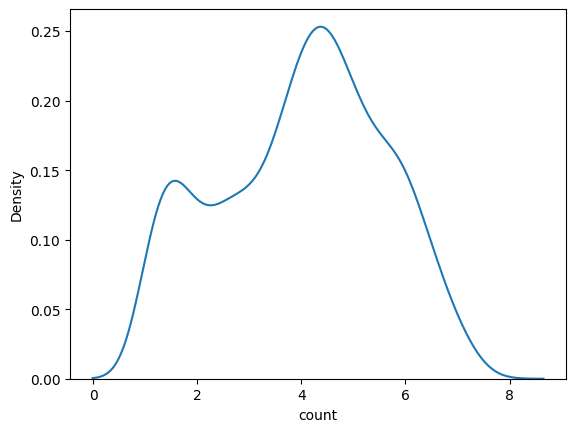

In [99]:
# transforming the distributions by cube root function
sns.kdeplot(x=pow(season1, 1/3))

<Axes: xlabel='count', ylabel='Density'>

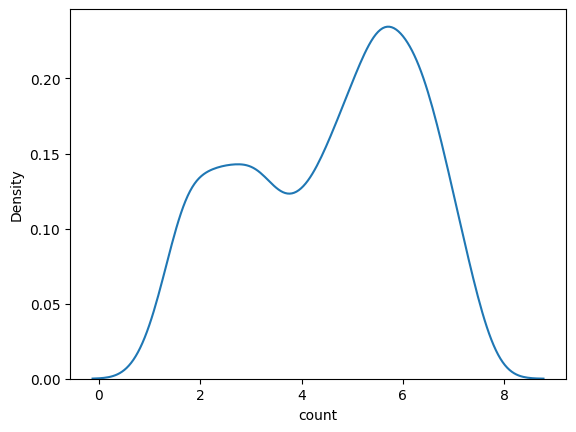

In [100]:
sns.kdeplot(x=pow(season2, 1/3))

<Axes: xlabel='count', ylabel='Density'>

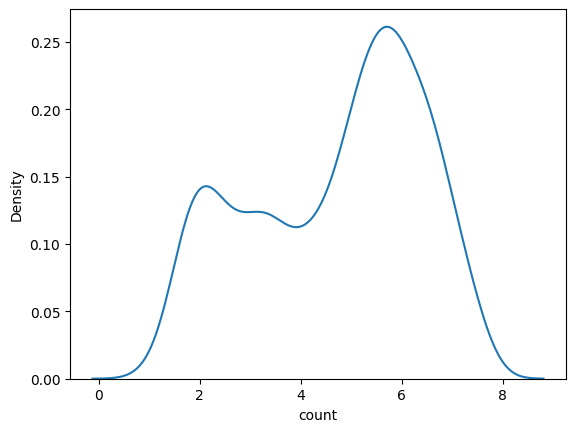

In [101]:
sns.kdeplot(x=pow(season3, 1/3))

<Axes: xlabel='count', ylabel='Density'>

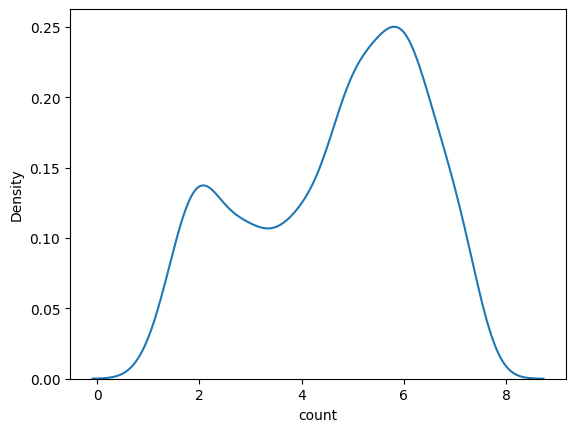

In [102]:
sns.kdeplot(x=pow(season4, 1/3))

In [103]:
season1 = pow(season1, 1/3)
season2 = pow(season2, 1/3)
season3 = pow(season3, 1/3)
season4 = pow(season4, 1/3)

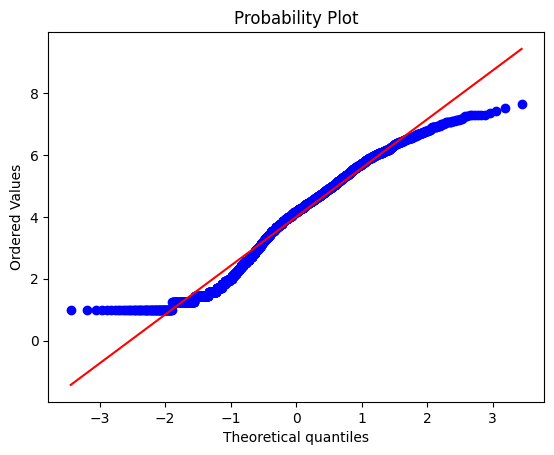

In [104]:
# Let's see how the QQplots have improved now
qqplot(season1)

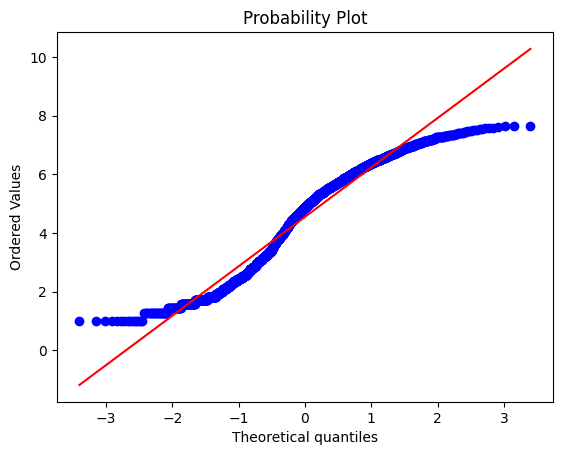

In [105]:
qqplot(season2)


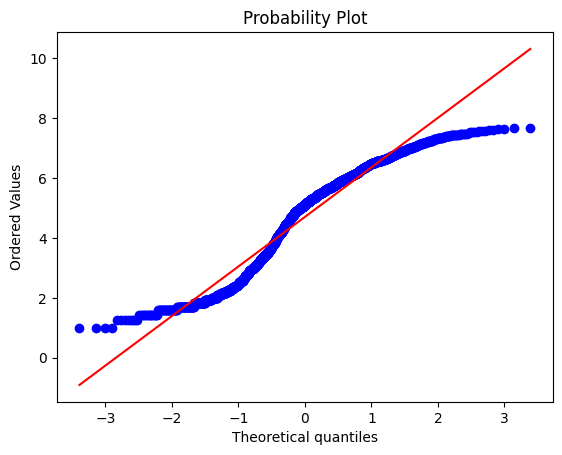

In [106]:
qqplot(season3)


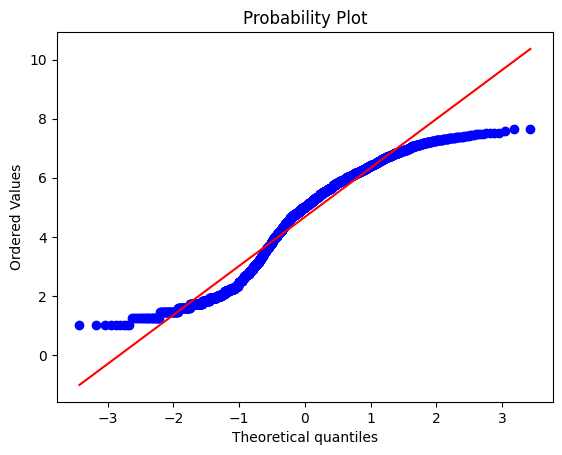

In [107]:
qqplot(season4)


The plots have slightly improved, but we can’t see a huge difference.

In [108]:
# Let's also re-do statistical test - Shapiro Wilk Test
i = 1
for s in [season1, season2, season3, season4]:
  print(f"## For season {i} ##")
  shapiro_wilk_test(season1, 0.05)
  print()
  i+=1


## For season 1 ##
p-value: 6.654774252843161e-21
Reject the Null Hypothesis

## For season 2 ##
p-value: 6.654774252843161e-21
Reject the Null Hypothesis

## For season 3 ##
p-value: 6.654774252843161e-21
Reject the Null Hypothesis

## For season 4 ##
p-value: 6.654774252843161e-21
Reject the Null Hypothesis



Shapiro Wilk Test says still it is probably not a gaussian dist since p-values are still less than 0.05
for any season, but they increased a but which means transformations had an positive impact to
some extent.

In [109]:
# let's check size of each sample
season1.shape, season2.shape, season3.shape, season4.shape

((2385,), (2050,), (1982,), (2290,))

Sample Sizes are somewhat similar which is good.

We observed that - Underlying distribution are not gaussian - Sample Size are same

Let’s anyways do the test of variance amongst these groups - ANOVA. (Performing final test)

In [111]:
alpha = 0.05
w_stats, p_value = stats.f_oneway(season1, season2, season3, season4)
print("p-value:", p_value)
if p_value > alpha :
  print("We do not reject the null hypothesis")
else:
  print("Reject the Null Hypothesis")

p-value: 9.907189446058677e-57
Reject the Null Hypothesis


ANOVA concluded in rejecting the null hypothesis i.e; we have enough evidence to say that probably
number of electric cycles rented are different across seasons.

Now, we will repeat the exact same process for Weather




**Question 3 - Is no. of cycles rented is similar in different weathers?** 

H0 : The count of
rented cycle is equal for different weather conditions.

Ha : The count of rented cycle is not equal for different weather conditions.

As, there are multiple group We will conduct a ANOVA Test.
Let’s take alpha to be = 0.05

First we will verify the assumptions for ANOVA

• The samples are drawn from a Gaussian distribution.

• The size of each sample is approximately equal.

• The samples have the same variance.

and then perform the actual test.

In [112]:
# Gathering observations
weather1 = df.loc[df['weather']==1, 'count']
weather2 = df.loc[df['weather']==2, 'count']
weather3 = df.loc[df['weather']==3, 'count']

<Axes: xlabel='count', ylabel='Density'>

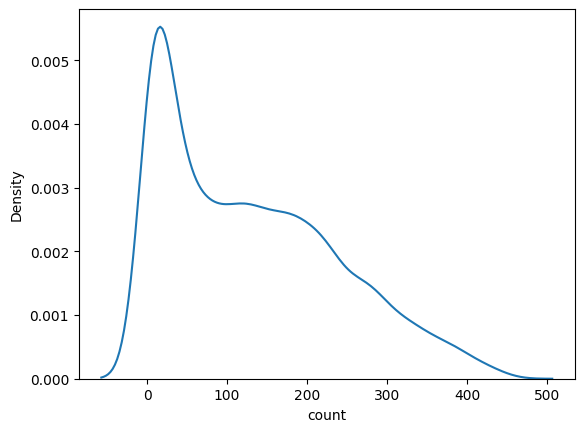

In [113]:
 # Let's check the distributions first.
sns.kdeplot(x=weather1)

<Axes: xlabel='count', ylabel='Density'>

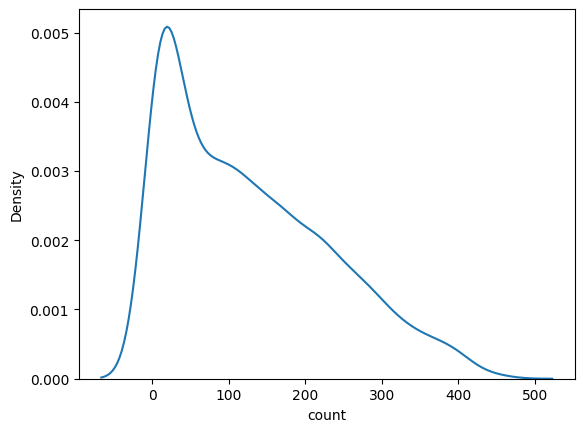

In [116]:
sns.kdeplot(x=weather2)

<Axes: xlabel='count', ylabel='Density'>

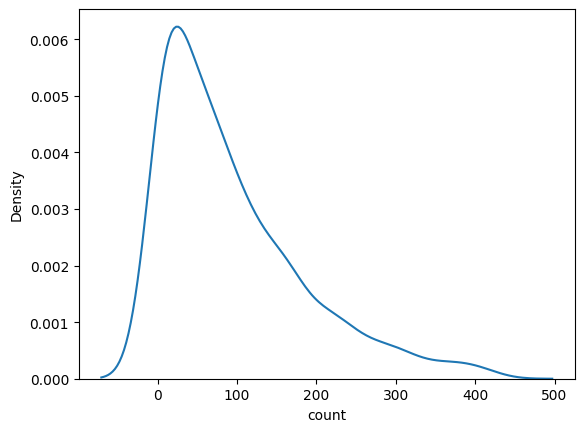

In [115]:
sns.kdeplot(x=weather3)


Similar to what saw earlier, these distributions are also postively skewed. 

Let’s try to tranform
this to close to gaussian.

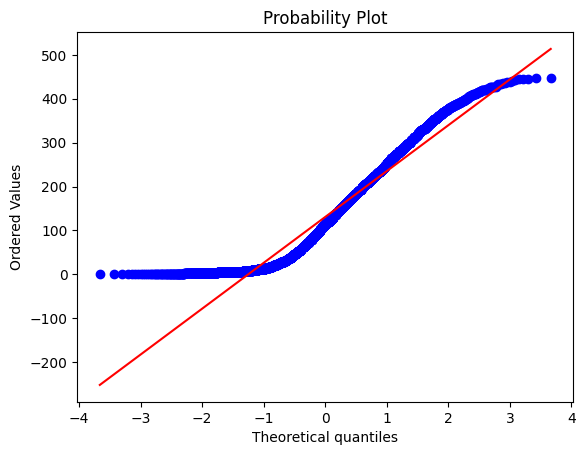

In [119]:
# Let's see how QQ plot is coming up
qqplot(weather1)

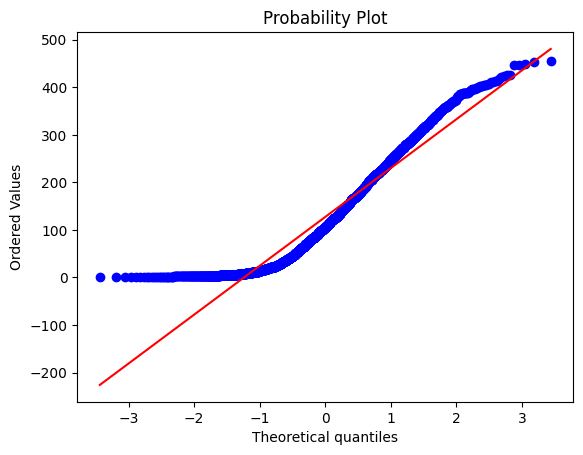

In [120]:
qqplot(weather2)

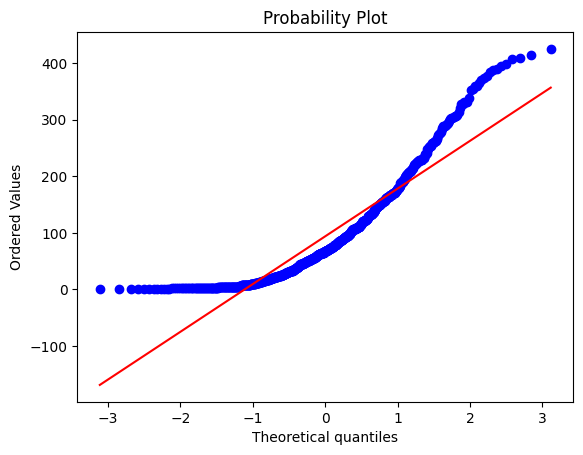

In [121]:
qqplot(weather3)

Again, We can see QQ Plot is not coming up good.

In [123]:
# Let's also do statistical test - Shapiro Wilk Test
i = 1
for s in [weather1, weather2, weather3]:
  print(f"## For weather {i} ##")
  shapiro_wilk_test(weather1, 0.05)
  print()
  i+=1

## For weather 1 ##
p-value: 0.0
Reject the Null Hypothesis

## For weather 2 ##
p-value: 0.0
Reject the Null Hypothesis

## For weather 3 ##
p-value: 0.0
Reject the Null Hypothesis



In [124]:
stats.boxcox(weather1)

(array([ 4.94685134,  8.13045732,  7.24910544, ..., 16.01948867,
        14.22343368, 11.92533229]),
 0.3839020945955021)

<Axes: xlabel='count', ylabel='Density'>

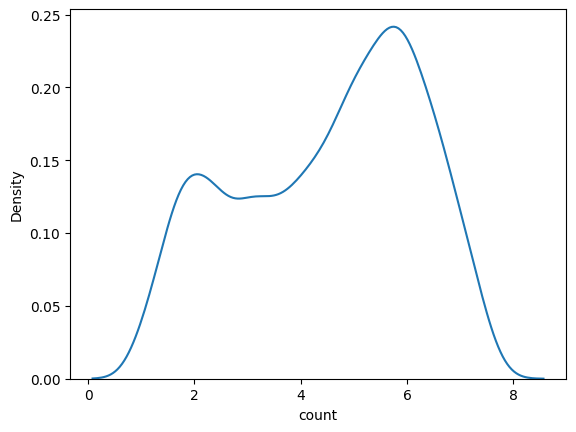

In [126]:
 # transforming the distributions by cube root function
sns.kdeplot(x=pow(weather1, 1/3))

<Axes: xlabel='count', ylabel='Density'>

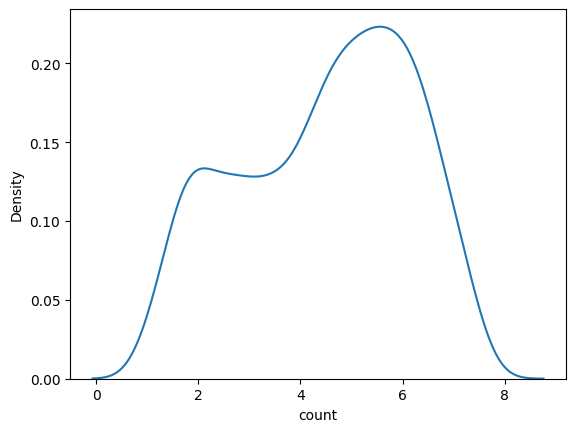

In [127]:
sns.kdeplot(x=pow(weather2, 1/3))


<Axes: xlabel='count', ylabel='Density'>

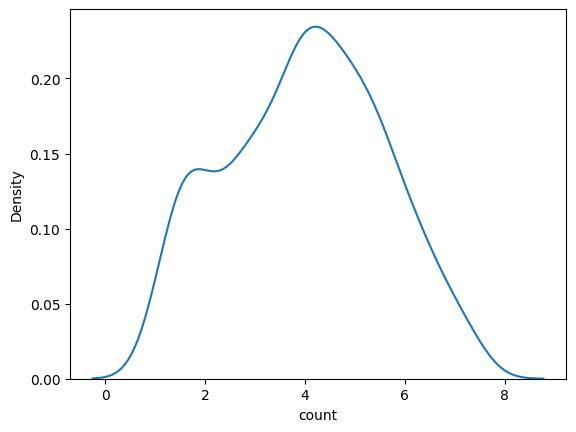

In [128]:
sns.kdeplot(x=pow(weather3, 1/3))


In [129]:
weather1 = pow(weather1, 1/3)
weather2 = pow(weather2, 1/3)
weather3 = pow(weather3, 1/3)

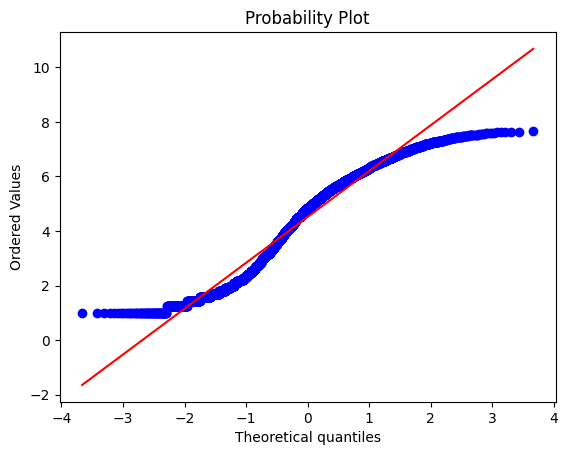

In [130]:
# Let's see how the QQplots have improved now
qqplot(weather1)

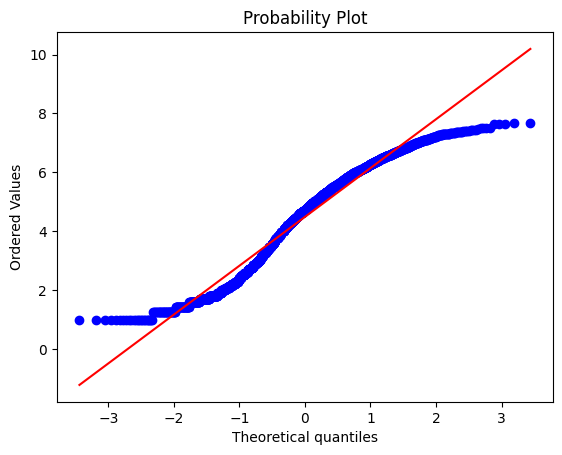

In [131]:
qqplot(weather2)

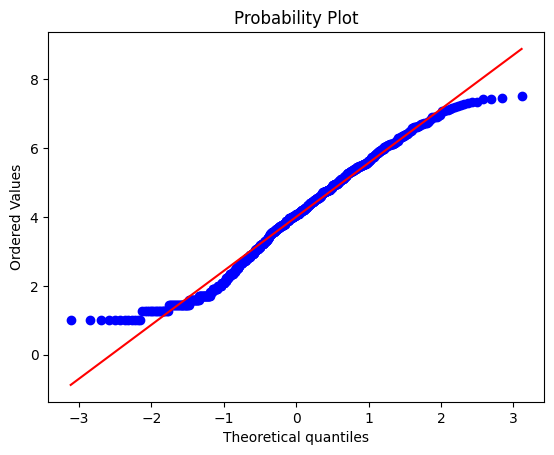

In [132]:
qqplot(weather3)

The plots have slightly improved, but we can’t see a huge difference.

In [134]:
# Let's also re-do statistical test - Shapiro Wilk Test
i = 1
for s in [weather1, weather2, weather3]:
  print(f"## For weather1 {i} ##")
  shapiro_wilk_test(weather1, 0.05)
  print()
  i+=1

## For weather1 1 ##
p-value: 2.6723190512004345e-38
Reject the Null Hypothesis

## For weather1 2 ##
p-value: 2.6723190512004345e-38
Reject the Null Hypothesis

## For weather1 3 ##
p-value: 2.6723190512004345e-38
Reject the Null Hypothesis



Shapiro Wilk Test says still it is probably not a gaussian dist since p-values are still less than 0.05
for any season, but they increased a but which means transformations had an positive impact to
some extent.

In [135]:
# let's check size of each sample
weather1.shape, weather2.shape, weather3.shape,

((5574,), (2382,), (751,))

Sample Sizes are different.
We observed that - Underlying distribution are not gaussian - Sample Size are different

Let’s anyways do the test of variance amongst these groups - ANOVA. (Performing final test)

In [136]:
alpha = 0.05
w_stats, p_value = stats.f_oneway(weather1, weather2, weather3)
print("p-value:", p_value)
if p_value > alpha :
  print("We do not reject the null hypothesis")
else:
  print("Reject the Null Hypothesis")

p-value: 4.773161796483209e-14
Reject the Null Hypothesis


ANOVA concluded in rejecting the null hypothesis i.e; we have enough evidence to say that probably
number of electric cycles rented are different for different weather conditions.

**Question 4 - Is weather dependent on season?**

H0 : Weather is independent of Season

HA : Weather is dependent on Season


In [137]:
season_weather_cross_table = pd.crosstab(index=df['season'],columns=df['weather'])
season_weather_cross_table

weather     1    2    3
season                 
1        1529  673  183
2        1289  567  194
3        1375  440  167
4        1381  702  207

<Axes: xlabel='season'>

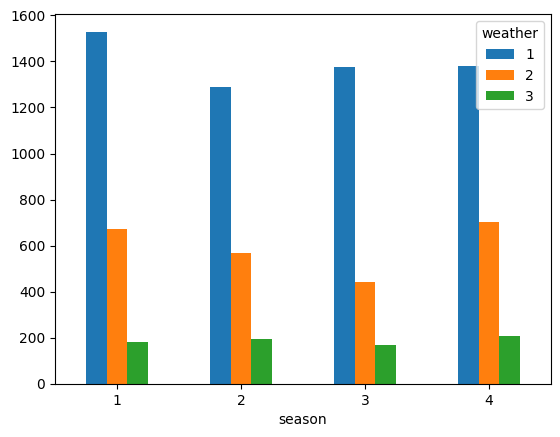

In [138]:
season_weather_cross_table.plot.bar(rot=0)

• If observe very carefully, weather 2 seems to have some realtionship with season as it happens
compartively less time for season 3 and 1.

• Otherwise, Weather seems to have very similar trend across all seasons.


In [139]:
alpha = 0.05
chi2_stat, p_value, dof, ex = stats.chi2_contingency(season_weather_cross_table)
print("p-value:", p_value)
if p_value > alpha :
  print("We do not reject the null hypothesis")
else:
  print("Reject the Null Hypothesis")

p-value: 1.158037425115846e-08
Reject the Null Hypothesis


Chi2 test concluded in rejecting the null hypothesis i.e; there is enough evidence to say that weather
is dependent on seasons.

**1.3 Observations**

Observations -

1. Data represents hourly count of electric cycles rented across 2 years (2011-2012)
2. For some reason, roughly 9% of the days have less than 24 data points.
3. Counts of electric bike rented by casual users are considerably smaller than that by registered
users, with a median of approximately 17 and 118 respectively.
4. Counts of electric bike rented is approximately uniform across days, with some hiccups due
to weather conditions in between.
5. Counts of electric bike rented is at it’s peak during day time, specially morning and evening
and considerably decreases during night.
6. We had only 1 instance of extreme weather (4) condition our data.
7. The data was equally distributed across seasons.
8. Features like temp, humidity and windspeed as clearly related to season, which is intuitive.
9. It is evident from visualizations that counts of electric cycles rented by casual users, registered
users and thus, all users are affected by season.
• Casual user rent more cycles in fall and summer as compared to winter and sprint. (fall >
summer > winter > spring)
• Registered user rent less cycles in spring, while the count of cycles rented by registered users
slowly increases from summer to winter (spring < summer < fall < winter) - which reflects
in the total counts as well.
10. People hire more rental bikes in pleasant and clear weather.
11. People are hire more rental bikes on working day, probably for commuting to work, as compared to other days.
12. Cloudy/Misty Weather (2) seems to occur slightly more during winter and spring.
13. From correlation matrix -
• temp positively affects casual, registered, total rental bike counts.
• humidity negatively affects casual, registered, total counts i.e; lower the humidity better the
rental bike counts.
• Weather has a negative correlation with rental bike counts i.e; better the weather higher the
rental bike counts.
14. Finally, We statistically proved that some of our observations

    • Count of rented bikes is affected if it is a working day or not.

    • Count of rented bikes is affected by season.

    • Count of rented bikes is affected by weather.

    • Weather is dependent on season.

##2 Recommendations
Yulu can introduce a dynamic pricing policy to adjust price rates in order to optimize the revenue
basis these factors which are evidently found to be affecting the behaviour of users and thus count
of rented bikes. 
- Weather : if weather is good we can slightly increase the price and if weather is
bad we can accordingly lower the price or provide some promotional offers to attract more users.
- Season : Price can be slightly adjusted during spring as we observed lower counts during spring
and be increased again in other seasons. - Working day : Higher pricing can be applied during
working days and some discounts can be given during week end to attract more users, specially
casual users.